# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [17]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=100):
    r"""
    Arguments:
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = $\lambda$
    num_iter_gd = number of GD iterations.

    Returns the result of kernel logistic regression :
    alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    Primal problem:
    $ \min_w  \sum_{i=1}^n \log(1+\exp(-y_i* \w^\top \phi(\x_i)))  + \frac{\lambda}{2} ||\w||^2 $

    the dual of which is

    $ \min_alpha \sum_{i=1}^n \log(1+\exp(-y_i* \alpha^\top K_{:,i} ))  + \frac{\lambda}{2} \alpha^\top K \alpha $
    where $\phi$ is the feature got by the kernel.

    Where K is the nxn kernel matrix computed on the training data.

    The kernel is defined by the kernel_param:
    If kernel=linear: K(\u,\v) = \u^\top \v  
    If kernel=poly:  K(\u,\v) = (1+\u^\top \v)^(kernel_param)
    If kernel=rbf:  K(\u,\v) = \exp(-kernel_param*||\u-\v||^2)
    """

    def Ker(u,v):
        if kernel == 'linear':
            return np.matmul(u,v.T)
        if kernel == 'poly':
            return (1+np.matmul(u,v.T))**kernel_param
        if kernel == 'rbf':
            return np.array(np.exp(-kernel_param*(np.linalg.norm(u-v))**2))
    
    def sig(U):
        if U <= -100:
            return 0
        if U >= 100:
            return 1
        return 1/(1+np.exp(-U))
    
    #Computing K matrix
    K = np.zeros([len(X),len(X)])
    for i in range(len(X)):
        for j in range(len(X)):
            K[i,j] = Ker(X[i,:],X[j,:])
    K = np.nan_to_num(K)
    a = np.zeros(len(X)) #Alpha matrix
    n = 10**-5 #Step size for gradient descent
    #Gradient descent
    for i in range(num_iter_gd):
        sum1 = 0
        for j in range(len(K)):
            sum1 += sig(-Y[j]*np.matmul(a,K[:,j]))*(-Y[j]*K[:,j])
        grad_R = sum1 + reg_param*np.matmul(K,a)
        a -= n*grad_R
    return a

def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param=1):
    """
    Return the predictions on test_X using the learnt alphas
    """
    def Ker(u,v):
        if kernel == 'linear':
            return np.matmul(u.T,v)
        if kernel == 'poly':
            return (1+np.matmul(u.T,v))**kernel_param
        if kernel == 'rbf':
            return np.array(np.exp(-kernel_param*(np.linalg.norm(u-v))**2))
    
    def sig(U):
        if U<=-100:
            return 0
        if U>=100:
            return 1
        return 1/(1+np.exp(-U))
    
    Y_pred = np.zeros(len(test_X))
    for i in range(len(test_X)):
        power = 0; #U from sig(U)
        for j in range(len(alpha)):
            K = Ker(train_X[j,:],test_X[i,:])
            K = np.nan_to_num(K)
            power += alpha[j]*K
        eta = sig(power)
        if eta >= 0.5:
            Y_pred[i] = 1
        else:
            Y_pred[i] = -1
            
    return Y_pred    

In [ ]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

dataset1_A = np.load('Data/dataset_A.npz')
dataset1_B = np.load('Data/dataset_B.npz')
dataset1_C = np.load('Data/dataset_C.npz')
dataset1_D = np.load('Data/dataset_D.npz')

X_train1_A = dataset1_A['arr_0']
Y_train1_A = dataset1_A['arr_1']
X_test1_A = dataset1_A['arr_2']
Y_test1_A = dataset1_A['arr_3']
np.random.seed(0)
indices = np.random.choice(range(X_train1_A.shape[0]),X_train1_A.shape[0]//5)
X_val1_A = X_train1_A[indices,:]
X_train_for_val1_A = np.delete(X_train1_A,indices,axis=0)
Y_val1_A = Y_train1_A[indices]
Y_train_for_val1_A = np.delete(Y_train1_A,indices,axis=0)

X_train1_B = dataset1_B['arr_0']
Y_train1_B = dataset1_B['arr_1']
X_test1_B = dataset1_B['arr_2']
Y_test1_B = dataset1_B['arr_3']
np.random.seed(0)
indices = np.random.choice(range(X_train1_B.shape[0]),X_train1_B.shape[0]//5)
X_val1_B = X_train1_B[indices,:]
X_train_for_val1_B = np.delete(X_train1_B,indices,axis=0)
Y_val1_B = Y_train1_B[indices]
Y_train_for_val1_B = np.delete(Y_train1_B,indices,axis=0)

X_train1_C = dataset1_C['arr_0']
Y_train1_C = dataset1_C['arr_1']
X_test1_C = dataset1_C['arr_2']
Y_test1_C = dataset1_C['arr_3']
np.random.seed(0)
indices = np.random.choice(range(X_train1_C.shape[0]),X_train1_C.shape[0]//5)
X_val1_C = X_train1_C[indices,:]
X_train_for_val1_C = np.delete(X_train1_C,indices,axis=0)
Y_val1_C = Y_train1_C[indices]
Y_train_for_val1_C = np.delete(Y_train1_C,indices,axis=0)

X_train1_D = dataset1_D['arr_0']
Y_train1_D = dataset1_D['arr_1']
X_test1_D = dataset1_D['arr_2']
Y_test1_D = dataset1_D['arr_3']
np.random.seed(0)
indices = np.random.choice(range(X_train1_D.shape[0]),X_train1_D.shape[0]//5)
X_val1_D = X_train1_D[indices,:]
X_train_for_val1_D = np.delete(X_train1_D,indices,axis=0)
Y_val1_D = Y_train1_D[indices]
Y_train_for_val1_D = np.delete(Y_train1_D,indices,axis=0)

reg_params = np.logspace(-4,3,8)
kernel_params = np.logspace(-4,3,8)
poly_kernel_params = np.linspace(2,9,8)

#print('\nDataset A')
max_accuracy = 0
for reg_param in reg_params:
    alpha = train_pred_logistic_regression(X_train_for_val1_A, Y_train_for_val1_A, kernel='linear', reg_param=reg_param, num_iter_gd=100)
    Y_pred_val = test_pred(alpha, X_train_for_val1_A, Y_train_for_val1_A, X_val1_A, kernel='linear')
    val_accuracy = np.sum(Y_val1_A == Y_pred_val)/Y_pred_val.shape[0]
    if val_accuracy > max_accuracy:
        max_accuracy = val_accuracy
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_A, Y_train1_A, kernel='linear', reg_param=reg_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_A, Y_train1_A, X_train1_A, kernel='linear')
Y_pred_test = test_pred(alpha, X_train1_A, Y_train1_A, X_test1_A, kernel='linear')
training_accuracy = np.sum(Y_pred_train == Y_train1_A)/Y_train1_A.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_A)/Y_test1_A.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_A, Y_train_for_val1_A, kernel='poly', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_A, Y_train_for_val1_A, X_val1_A, kernel='poly', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_A == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_A, Y_train1_A, kernel='poly', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_A, Y_train1_A, X_train1_A, kernel='poly', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_A, Y_train1_A, X_test1_A, kernel='poly', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_A)/Y_train1_A.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_A)/Y_test1_A.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))


max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_A, Y_train_for_val1_A, kernel='rbf', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_A, Y_train_for_val1_A, X_val1_A, kernel='rbf', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_A == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_A, Y_train1_A, kernel='rbf', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_A, Y_train1_A, X_train1_A, kernel='rbf', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_A, Y_train1_A, X_test1_A, kernel='rbf', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_A)/Y_train1_A.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_A)/Y_test1_A.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

#print('\nDataset B')
max_accuracy = 0
for reg_param in reg_params:
    alpha = train_pred_logistic_regression(X_train_for_val1_B, Y_train_for_val1_B, kernel='linear', reg_param=reg_param, num_iter_gd=100)
    Y_pred_val = test_pred(alpha, X_train_for_val1_B, Y_train_for_val1_B, X_val1_B, kernel='linear')
    val_accuracy = np.sum(Y_val1_B == Y_pred_val)/Y_pred_val.shape[0]
    if val_accuracy > max_accuracy:
        max_accuracy = val_accuracy
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_B, Y_train1_B, kernel='linear', reg_param=reg_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_B, Y_train1_B, X_train1_B, kernel='linear')
Y_pred_test = test_pred(alpha, X_train1_B, Y_train1_B, X_test1_B, kernel='linear')
training_accuracy = np.sum(Y_pred_train == Y_train1_B)/Y_train1_B.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_B)/Y_test1_B.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_B, Y_train_for_val1_B, kernel='poly', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_B, Y_train_for_val1_B, X_val1_B, kernel='poly', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_B == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_B, Y_train1_B, kernel='poly', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_B, Y_train1_B, X_train1_B, kernel='poly', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_B, Y_train1_B, X_test1_B, kernel='poly', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_B)/Y_train1_B.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_B)/Y_test1_B.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))


max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_B, Y_train_for_val1_B, kernel='rbf', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_B, Y_train_for_val1_B, X_val1_B, kernel='rbf', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_B == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_B, Y_train1_B, kernel='rbf', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_B, Y_train1_B, X_train1_B, kernel='rbf', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_B, Y_train1_B, X_test1_B, kernel='rbf', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_B)/Y_train1_B.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_B)/Y_test1_B.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

#print('\nDataset C')
max_accuracy = 0
for reg_param in reg_params:
    alpha = train_pred_logistic_regression(X_train_for_val1_C, Y_train_for_val1_C, kernel='linear', reg_param=reg_param, num_iter_gd=100)
    Y_pred_val = test_pred(alpha, X_train_for_val1_C, Y_train_for_val1_C, X_val1_C, kernel='linear')
    val_accuracy = np.sum(Y_val1_C == Y_pred_val)/Y_pred_val.shape[0]
    if val_accuracy > max_accuracy:
        max_accuracy = val_accuracy
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_C, Y_train1_C, kernel='linear', reg_param=reg_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_C, Y_train1_C, X_train1_C, kernel='linear')
Y_pred_test = test_pred(alpha, X_train1_C, Y_train1_C, X_test1_C, kernel='linear')
training_accuracy = np.sum(Y_pred_train == Y_train1_C)/Y_train1_C.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_C)/Y_test1_C.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_C, Y_train_for_val1_C, kernel='poly', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_C, Y_train_for_val1_C, X_val1_C, kernel='poly', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_C == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_C, Y_train1_C, kernel='poly', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_C, Y_train1_C, X_train1_C, kernel='poly', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_C, Y_train1_C, X_test1_C, kernel='poly', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_C)/Y_train1_C.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_C)/Y_test1_C.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))


max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_C, Y_train_for_val1_C, kernel='rbf', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_C, Y_train_for_val1_C, X_val1_C, kernel='rbf', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_C == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_C, Y_train1_C, kernel='rbf', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_C, Y_train1_C, X_train1_C, kernel='rbf', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_C, Y_train1_C, X_test1_C, kernel='rbf', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_C)/Y_train1_C.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_C)/Y_test1_C.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

#print('Dataset D')
max_accuracy = 0
for reg_param in reg_params:
    alpha = train_pred_logistic_regression(X_train_for_val1_D, Y_train_for_val1_D, kernel='linear', reg_param=reg_param, num_iter_gd=100)
    Y_pred_val = test_pred(alpha, X_train_for_val1_D, Y_train_for_val1_D, X_val1_D, kernel='linear')
    val_accuracy = np.sum(Y_val1_D == Y_pred_val)/Y_pred_val.shape[0]
    if val_accuracy > max_accuracy:
        max_accuracy = val_accuracy
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_D, Y_train1_D, kernel='linear', reg_param=reg_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_D, Y_train1_D, X_train1_D, kernel='linear')
Y_pred_test = test_pred(alpha, X_train1_D, Y_train1_D, X_test1_D, kernel='linear')
training_accuracy = np.sum(Y_pred_train == Y_train1_D)/Y_train1_D.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_D)/Y_test1_D.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))

max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_D, Y_train_for_val1_D, kernel='poly', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_D, Y_train_for_val1_D, X_val1_D, kernel='poly', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_D == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_D, Y_train1_D, kernel='poly', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_D, Y_train1_D, X_train1_D, kernel='poly', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_D, Y_train1_D, X_test1_D, kernel='poly', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_D)/Y_train1_D.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_D)/Y_test1_D.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))


max_accuracy = 0
for reg_param in reg_params:
    for kernel_param in kernel_params:
        alpha = train_pred_logistic_regression(X_train_for_val1_D, Y_train_for_val1_D, kernel='rbf', reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=100)
        Y_pred_val = test_pred(alpha, X_train_for_val1_D, Y_train_for_val1_D, X_val1_D, kernel='rbf', kernel_param=kernel_param)
        val_accuracy = np.sum(Y_val1_D == Y_pred_val)/Y_pred_val.shape[0]
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('Accuracy: '+str(max_accuracy))
alpha = train_pred_logistic_regression(X_train1_D, Y_train1_D, kernel='rbf', reg_param=reg_param_opt, kernel_param=kernel_param_opt, num_iter_gd=100)
Y_pred_train = test_pred(alpha, X_train1_D, Y_train1_D, X_train1_D, kernel='rbf', kernel_param=kernel_param_opt)
Y_pred_test = test_pred(alpha, X_train1_D, Y_train1_D, X_test1_D, kernel='rbf', kernel_param=kernel_param_opt)
training_accuracy = np.sum(Y_pred_train == Y_train1_D)/Y_train1_D.shape[0]
test_accuracy = np.sum(Y_pred_test == Y_test1_D)/Y_test1_D.shape[0]
training_loss = 1 - training_accuracy
test_loss = 1 - test_accuracy
#print('Training Loss: '+str(training_loss))
#print('Test Loss: '+str(test_loss))


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  


## **Observations**
From the plots of Dataset A and B we can see that none of them are linearly separable therefore the linear kernel shows a lower accuracy. The polynomial as the name suggests creates a polynomial decision boundary but it is unable to create a good decision boundary for the given datasets. However, the RBF kernel uses radial distance from the datapoints and can therefore classify the given dataset.

###Dataset A
####Linear Kernel
Regularisation Parameter = 1e-4
Train 0-1 Loss = 0.130
Test 0-1 Loss = 0.150

####Polynomial Kernel
Regularisation Parameter = 1e-3
Kernel Parameter = 3
Train 0-1 Loss = 0.145
Test 0-1 Loss = 0.174

####RBF Kernel
Regularisation Parameter = 1e-4
Kernel Parameter = 100
Train 0-1 Loss = 0
Test 0-1 Loss = 0.002

###Dataset B
####Linear Kernel
Regularisation Parameter = 1e-4
Train 0-1 Loss = 0.175
Test 0-1 Loss = 0.199

####Polynomial Kernel
Regularisation Parameter = 1
Kernel Parameter = 4
Train 0-1 Loss = 0.175
Test 0-1 Loss = 0.194

####RBF Kernel
Regularisation Parameter = 10
Kernel Parameter = 10
Train 0-1 Loss = 0.175
Test 0-1 Loss = 0.199

###Dataset C
####Linear Kernel
Regularisation Parameter = 1e-4
Train 0-1 Loss = 0.475
Test 0-1 Loss = 0.478

####Polynomial Kernel
Regularisation Parameter = 1e-4
Kernel Parameter = 2
Train 0-1 Loss = 0.497
Test 0-1 Loss = 0.488

####RBF Kernel
Regularisation Parameter = 1e-4
Kernel Parameter = 0.01
Train 0-1 Loss = 0
Test 0-1 Loss = 0.03

###Dataset D
####Linear Kernel
Regularisation Parameter = 1
Train 0-1 Loss = 0.5675
Test 0-1 Loss = 0.769

####Polynomial Kernel
Regularisation Parameter = 1e-4
Kernel Parameter = 2
Train 0-1 Loss = 0.5675
Test 0-1 Loss = 0.769

####RBF Kernel
Regularisation Parameter = 1000
Kernel Parameter = 1e-4
Train 0-1 Loss = 0.0925
Test 0-1 Loss = 0.053




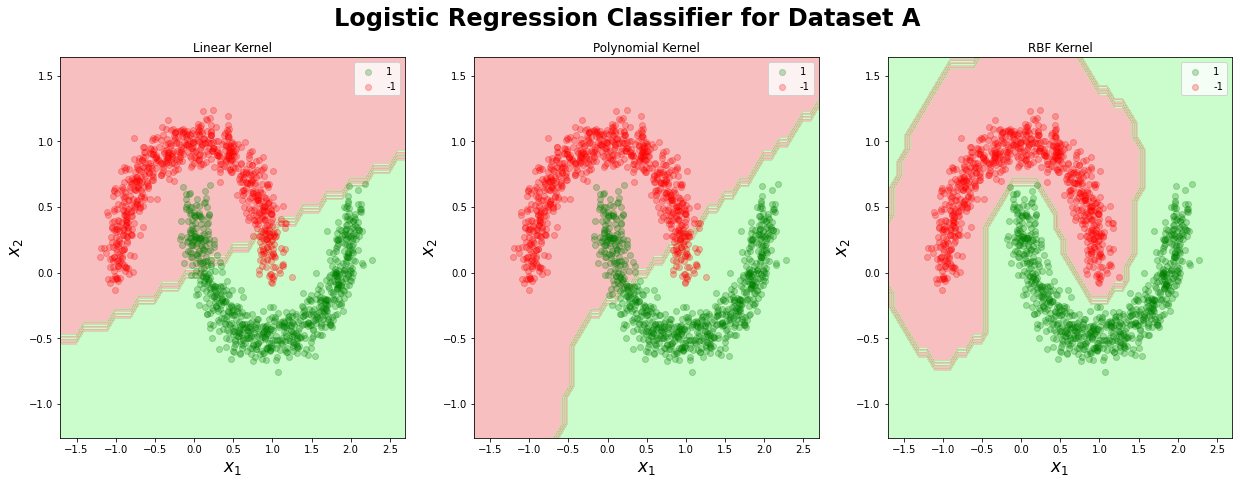

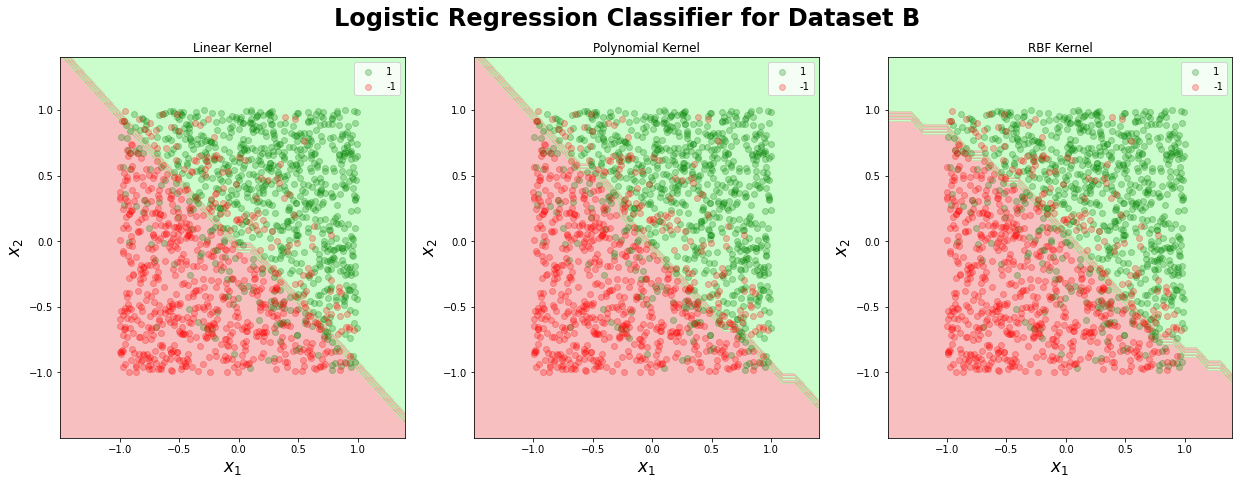

In [3]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

dataset1_A = np.load('Data/dataset_A.npz')
dataset1_B = np.load('Data/dataset_B.npz')

X_train1_A = dataset1_A['arr_0']
Y_train1_A = dataset1_A['arr_1']
X_test1_A = dataset1_A['arr_2']
Y_test1_A = dataset1_A['arr_3']

X_train1_B = dataset1_B['arr_0']
Y_train1_B = dataset1_B['arr_1']
X_test1_B = dataset1_B['arr_2']
Y_test1_B = dataset1_B['arr_3']


X_axis1, Y_axis1 = np.meshgrid(np.arange(start = X_train1_A[:, 0].min() - 0.5, stop = X_train1_A[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train1_A[:, 1].min() - 0.5, stop = X_train1_A[:, 1].max() + 0.5, step = 0.1))
X_test1 = np.array([X_axis1.ravel(), Y_axis1.ravel()]).T


X_axis2, Y_axis2 = np.meshgrid(np.arange(start = X_train1_B[:, 0].min() - 0.5, stop = X_train1_B[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train1_B[:, 1].min() - 0.5, stop = X_train1_B[:, 1].max() + 0.5, step = 0.1))
X_test2 = np.array([X_axis2.ravel(), Y_axis2.ravel()]).T


plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Logistic Regression Classifier for Dataset A', fontweight='bold',fontsize=24)

#Data A

#Linear
alpha = train_pred_logistic_regression(X_train1_A, Y_train1_A, kernel='linear', reg_param=0.0001, kernel_param=1, num_iter_gd=100)
Y_pred = test_pred(alpha, X_train1_A, Y_train1_A, X_test1, kernel='linear', kernel_param=1)
Z = Y_pred.reshape(X_axis1.shape)
ax[0].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[0].scatter(X_train1_A[Y_train1_A==1][:,0],X_train1_A[Y_train1_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[0].scatter(X_train1_A[Y_train1_A==-1][:,0],X_train1_A[Y_train1_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[0].set_title('Linear Kernel')
ax[0].legend()
ax[0].set_xlabel('$x_1$',fontsize=17)
ax[0].set_ylabel('$x_2$',fontsize=17)

#Poly
alpha = train_pred_logistic_regression(X_train1_A, Y_train1_A, kernel='poly', reg_param=0.001, kernel_param=3, num_iter_gd=100)
Y_pred = test_pred(alpha, X_train1_A, Y_train1_A, X_test1, kernel='poly', kernel_param=3)
Z = Y_pred.reshape(X_axis1.shape)
ax[1].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[1].scatter(X_train1_A[Y_train1_A==1][:,0],X_train1_A[Y_train1_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[1].scatter(X_train1_A[Y_train1_A==-1][:,0],X_train1_A[Y_train1_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[1].set_title('Polynomial Kernel')
ax[1].legend()
ax[1].set_xlabel('$x_1$',fontsize=17)
ax[1].set_ylabel('$x_2$',fontsize=17)

#RBF
alpha = train_pred_logistic_regression(X_train1_A, Y_train1_A, kernel='rbf', reg_param=0.0001, kernel_param=100, num_iter_gd=100)
Y_pred = test_pred(alpha, X_train1_A, Y_train1_A, X_test1, kernel='rbf', kernel_param=100)
Z = Y_pred.reshape(X_axis1.shape)
ax[2].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[2].scatter(X_train1_A[Y_train1_A==1][:,0],X_train1_A[Y_train1_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[2].scatter(X_train1_A[Y_train1_A==-1][:,0],X_train1_A[Y_train1_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[2].set_title('RBF Kernel')
ax[2].legend()
ax[2].set_xlabel('$x_1$',fontsize=17)
ax[2].set_ylabel('$x_2$',fontsize=17)

plt.show()

fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Logistic Regression Classifier for Dataset B', fontweight='bold',fontsize=24)

#Data B

#Linear
alpha = train_pred_logistic_regression(X_train1_B, Y_train1_B, kernel='linear', reg_param=0.0001, kernel_param=1, num_iter_gd=100)
Y_pred = test_pred(alpha, X_train1_B, Y_train1_B, X_test2, kernel='linear', kernel_param=1)
Z = Y_pred.reshape(X_axis2.shape)
ax[0].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[0].scatter(X_train1_B[Y_train1_B==1][:,0],X_train1_B[Y_train1_B==1][:,1], color = 'green',alpha=0.25,label='1')
ax[0].scatter(X_train1_B[Y_train1_B==-1][:,0],X_train1_B[Y_train1_B==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[0].set_title('Linear Kernel')
ax[0].legend()
ax[0].set_xlabel('$x_1$',fontsize=17)
ax[0].set_ylabel('$x_2$',fontsize=17)

#Poly
alpha = train_pred_logistic_regression(X_train1_B, Y_train1_B, kernel='poly', reg_param=1, kernel_param=4, num_iter_gd=100)
Y_pred = test_pred(alpha, X_train1_B, Y_train1_B, X_test2, kernel='poly', kernel_param=4)
Z = Y_pred.reshape(X_axis2.shape)
ax[1].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[1].scatter(X_train1_B[Y_train1_B==1][:,0],X_train1_B[Y_train1_B==1][:,1], color = 'green',alpha=0.25,label='1')
ax[1].scatter(X_train1_B[Y_train1_B==-1][:,0],X_train1_B[Y_train1_B==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[1].set_title('Polynomial Kernel')
ax[1].legend()
ax[1].set_xlabel('$x_1$',fontsize=17)
ax[1].set_ylabel('$x_2$',fontsize=17)

#RBF
alpha = train_pred_logistic_regression(X_train1_B, Y_train1_B, kernel='rbf', reg_param=10, kernel_param=10, num_iter_gd=100)
Y_pred = test_pred(alpha, X_train1_B, Y_train1_B, X_test2, kernel='rbf', kernel_param=10)
Z = Y_pred.reshape(X_axis2.shape)
ax[2].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[2].scatter(X_train1_B[Y_train1_B==1][:,0],X_train1_B[Y_train1_B==1][:,1], color = 'green',alpha=0.25,label='1')
ax[2].scatter(X_train1_B[Y_train1_B==-1][:,0],X_train1_B[Y_train1_B==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[2].set_title('RBF Kernel')
ax[2].legend()
ax[2].set_xlabel('$x_1$',fontsize=17)
ax[2].set_ylabel('$x_2$',fontsize=17)

plt.show()

# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [4]:
# CodeWrite cell
# Write SVM classifier using Sklearn
# write only functions here

def train_svm(X,Y,reg_param,kernel,kernel_param=1):
    if kernel == 'linear':
        clf = svm.SVC(C=reg_param,kernel=kernel,degree=1)
        
    if kernel == 'poly':
        clf = svm.SVC(C=reg_param,kernel=kernel,degree=kernel_param)
        
    if kernel == 'rbf':
        clf = svm.SVC(C=reg_param,kernel=kernel,gamma=kernel_param)
        
    clf = clf.fit(X,Y)
    return clf

In [ ]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.

dataset2_A = np.load('Data/dataset_A.npz')
dataset2_B = np.load('Data/dataset_B.npz')
dataset2_C = np.load('Data/dataset_C.npz')
dataset2_D = np.load('Data/dataset_D.npz')

X_train2_A = dataset2_A['arr_0']
Y_train2_A = dataset2_A['arr_1']
X_test2_A = dataset2_A['arr_2']
Y_test2_A = dataset2_A['arr_3']
indices = np.random.choice(range(X_train2_A.shape[0]),X_train2_A.shape[0]//5)
X_val2_A = X_train2_A[indices,:]
X_train_for_val2_A = np.delete(X_train2_A,indices,axis=0)
Y_val2_A = Y_train2_A[indices]
Y_train_for_val2_A = np.delete(Y_train2_A,indices,axis=0)


X_train2_B = dataset2_B['arr_0']
Y_train2_B = dataset2_B['arr_1']
X_test2_B = dataset2_B['arr_2']
Y_test2_B = dataset2_B['arr_3']
indices = np.random.choice(range(X_train2_B.shape[0]),X_train2_B.shape[0]//5)
X_val2_B = X_train2_B[indices,:]
X_train_for_val2_B = np.delete(X_train2_B,indices,axis=0)
Y_val2_B = Y_train2_B[indices]
Y_train_for_val2_B = np.delete(Y_train2_B,indices,axis=0)


X_train2_C = dataset2_C['arr_0']
Y_train2_C = dataset2_C['arr_1']
X_test2_C = dataset2_C['arr_2']
Y_test2_C = dataset2_C['arr_3']
indices = np.random.choice(range(X_train2_C.shape[0]),X_train2_C.shape[0]//5)
X_val2_C = X_train2_C[indices,:]
X_train_for_val2_C = np.delete(X_train2_C,indices,axis=0)
Y_val2_C = Y_train2_C[indices]
Y_train_for_val2_C = np.delete(Y_train2_C,indices,axis=0)



X_train2_D = dataset2_D['arr_0']
Y_train2_D = dataset2_D['arr_1']
X_test2_D = dataset2_D['arr_2']
Y_test2_D = dataset2_D['arr_3']
indices = np.random.choice(range(X_train2_D.shape[0]),X_train2_D.shape[0]//5)
X_val2_D = X_train2_D[indices,:]
X_train_for_val2_D = np.delete(X_train2_D,indices,axis=0)
Y_val2_D = Y_train2_D[indices]
Y_train_for_val2_D = np.delete(Y_train2_D,indices,axis=0)



reg_params = np.logspace(-4,3,8)
kernel_params = np.logspace(-4,3,8)
poly_kernel_params = np.linspace(2,9,8)


# Dataset A
#print('\n\nDataset A')
min_loss = 1
for reg_param in reg_params:
    Y_pred_val = train_svm(X_train_for_val2_A,Y_train_for_val2_A,reg_param,'linear').predict(X_val2_A)
    val_accuracy = np.sum(Y_val2_A == Y_pred_val)/Y_pred_val.shape[0]
    loss = 1 - val_accuracy
    if min_loss > loss:
        min_loss = loss
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_A,Y_train2_A,reg_param_opt,'linear')
Y_pred_train = learned_model.predict(X_train2_A)
train_accuracy = np.sum(Y_train2_A == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_A)
test_accuracy = np.sum(Y_test2_A == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_A,Y_train_for_val2_A,reg_param,'poly',kernel_param).predict(X_val2_A)
        val_accuracy = np.sum(Y_val2_A == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_A,Y_train2_A,reg_param_opt,'poly',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_A)
train_accuracy = np.sum(Y_train2_A == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_A)
test_accuracy = np.sum(Y_test2_A == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_A,Y_train_for_val2_A,reg_param,'rbf',kernel_param).predict(X_val2_A)
        val_accuracy = np.sum(Y_val2_A == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_A,Y_train2_A,reg_param_opt,'rbf',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_A)
train_accuracy = np.sum(Y_train2_A == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_A)
test_accuracy = np.sum(Y_test2_A == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

# Dataset B
#print('\n\nDataset B')
min_loss = 1
for reg_param in reg_params:
    Y_pred_val = train_svm(X_train_for_val2_B,Y_train_for_val2_B,reg_param,'linear').predict(X_val2_B)
    val_accuracy = np.sum(Y_val2_B == Y_pred_val)/Y_pred_val.shape[0]
    loss = 1 - val_accuracy
    if min_loss > loss:
        min_loss = loss
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_B,Y_train2_B,reg_param_opt,'linear')
Y_pred_train = learned_model.predict(X_train2_B)
train_accuracy = np.sum(Y_train2_B == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_B)
test_accuracy = np.sum(Y_test2_B == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_B,Y_train_for_val2_B,reg_param,'poly',kernel_param).predict(X_val2_B)
        val_accuracy = np.sum(Y_val2_B == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_B,Y_train2_B,reg_param_opt,'poly',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_B)
train_accuracy = np.sum(Y_train2_B == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_B)
test_accuracy = np.sum(Y_test2_B == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_B,Y_train_for_val2_B,reg_param,'rbf',kernel_param).predict(X_val2_B)
        val_accuracy = np.sum(Y_val2_B == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_B,Y_train2_B,reg_param_opt,'rbf',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_B)
train_accuracy = np.sum(Y_train2_B == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_B)
test_accuracy = np.sum(Y_test2_B == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

# Dataset C
#print('\n\nDataset C')
min_loss = 1
for reg_param in reg_params:
    Y_pred_val = train_svm(X_train_for_val2_C,Y_train_for_val2_C,reg_param,'linear').predict(X_val2_C)
    val_accuracy = np.sum(Y_val2_C == Y_pred_val)/Y_pred_val.shape[0]
    loss = 1 - val_accuracy
    if min_loss > loss:
        min_loss = loss
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_C,Y_train2_C,reg_param_opt,'linear')
Y_pred_train = learned_model.predict(X_train2_C)
train_accuracy = np.sum(Y_train2_C == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_C)
test_accuracy = np.sum(Y_test2_C == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_C,Y_train_for_val2_C,reg_param,'poly',kernel_param).predict(X_val2_C)
        val_accuracy = np.sum(Y_val2_C == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_C,Y_train2_C,reg_param_opt,'poly',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_C)
train_accuracy = np.sum(Y_train2_C == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_C)
test_accuracy = np.sum(Y_test2_C == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_C,Y_train_for_val2_C,reg_param,'rbf',kernel_param).predict(X_val2_C)
        val_accuracy = np.sum(Y_val2_C == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_C,Y_train2_C,reg_param_opt,'rbf',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_C)
train_accuracy = np.sum(Y_train2_C == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_C)
test_accuracy = np.sum(Y_test2_C == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

# Dataset D
#print('\n\nDataset D')
min_loss = 1
for reg_param in reg_params:
    Y_pred_val = train_svm(X_train_for_val2_D,Y_train_for_val2_D,reg_param,'linear').predict(X_val2_D)
    val_accuracy = np.sum(Y_val2_D == Y_pred_val)/Y_pred_val.shape[0]
    loss = 1 - val_accuracy
    if min_loss > loss:
        min_loss = loss
        reg_param_opt = reg_param
#print('\nKernel: linear')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_D,Y_train2_D,reg_param_opt,'linear')
Y_pred_train = learned_model.predict(X_train2_D)
train_accuracy = np.sum(Y_train2_D == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_D)
test_accuracy = np.sum(Y_test2_D == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in poly_kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_D,Y_train_for_val2_D,reg_param,'poly',kernel_param).predict(X_val2_D)
        val_accuracy = np.sum(Y_val2_D == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: poly')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_D,Y_train2_D,reg_param_opt,'poly',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_D)
train_accuracy = np.sum(Y_train2_D == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_D)
test_accuracy = np.sum(Y_test2_D == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))

min_loss = 1
for reg_param in reg_params:
    for kernel_param in kernel_params:
        Y_pred_val = train_svm(X_train_for_val2_D,Y_train_for_val2_D,reg_param,'rbf',kernel_param).predict(X_val2_D)
        val_accuracy = np.sum(Y_val2_D == Y_pred_val)/Y_pred_val.shape[0]
        loss = 1 - val_accuracy
        if min_loss > loss:
            min_loss = loss
            reg_param_opt = reg_param
            kernel_param_opt = kernel_param
#print('\nKernel: rbf')
#print('Best regularisation parameter: '+str(reg_param_opt))
#print('Best kernel parameter: '+str(kernel_param_opt))
#print('0-1 Loss (on validation set): '+str(min_loss))
learned_model = train_svm(X_train2_D,Y_train2_D,reg_param_opt,'rbf',kernel_param_opt)
Y_pred_train = learned_model.predict(X_train2_D)
train_accuracy = np.sum(Y_train2_D == Y_pred_train)/Y_pred_train.shape[0]
train_loss = 1 - train_accuracy
#print('Training 0-1 error : '+str(train_loss))
Y_pred_test = learned_model.predict(X_test2_D)
test_accuracy = np.sum(Y_test2_D == Y_pred_test)/Y_pred_test.shape[0]
test_loss = 1 - test_accuracy
#print('Test 0-1 error : '+str(test_loss))



TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

##Observations
SVM is similar to Logistic regression in the sense that we use the same kernel functions. From the plots of Dataset A and B we can see that none of them are linearly separable therefore the linear kernel shows a lower accuracy. The polynomial as the name suggests creates a polynomial decision boundary creates a better split. However, the RBF kernel uses radial distance from the datapoints and can therefore classify the given dataset.

###Dataset A
####Linear Kernel
Regularisation Parameter = 1
Train 0-1 Loss = 0.129
Test 0-1 Loss = 0.134

####Polynomial Kernel
Regularisation Parameter = 0.1
Kernel Parameter = 5
Train 0-1 Loss = 0.063
Test 0-1 Loss = 0.084

####RBF Kernel
Regularisation Parameter = 0.1
Kernel Parameter = 10
Train 0-1 Loss = 0.0013
Test 0-1 Loss = 0.002

###Dataset B
####Linear Kernel
Regularisation Parameter = 0.1
Train 0-1 Loss = 0.175
Test 0-1 Loss = 0.196

####Polynomial Kernel
Regularisation Parameter = 100
Kernel Parameter = 3
Train 0-1 Loss = 0.176
Test 0-1 Loss = 0.202

####RBF Kernel
Regularisation Parameter = 1000
Kernel Parameter = 1e-4
Train 0-1 Loss = 0.177
Test 0-1 Loss = 0.204

###Dataset C
####Linear Kernel
Regularisation Parameter = 0.01
Train 0-1 Loss = 0.069
Test 0-1 Loss = 0.111

####Polynomial Kernel
Regularisation Parameter = 10
Kernel Parameter = 2
Train 0-1 Loss = 0.00067
Test 0-1 Loss = 0.047

####RBF Kernel
Regularisation Parameter = 1
Kernel Parameter = 0.001
Train 0-1 Loss = 0
Test 0-1 Loss = 0.024

###Dataset D
####Linear Kernel
Regularisation Parameter = 0.01
Train 0-1 Loss = 0.045
Test 0-1 Loss = 0.083

####Polynomial Kernel
Regularisation Parameter = 1000
Kernel Parameter = 2
Train 0-1 Loss = 0.0525
Test 0-1 Loss = 0.065

####RBF Kernel
Regularisation Parameter = 10
Kernel Parameter = 1e-4
Train 0-1 Loss = 0.0275
Test 0-1 Loss = 0.071


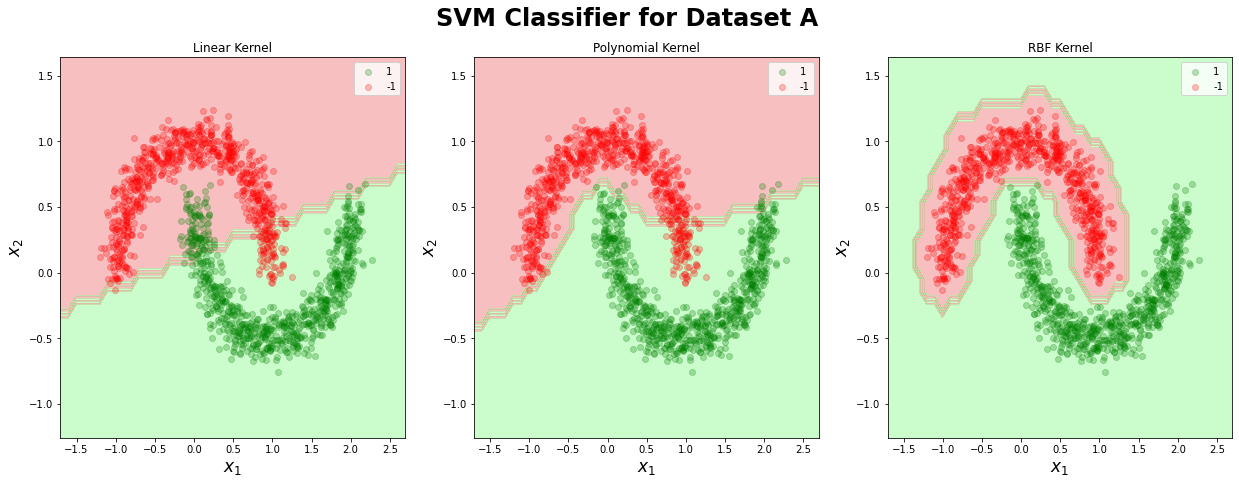

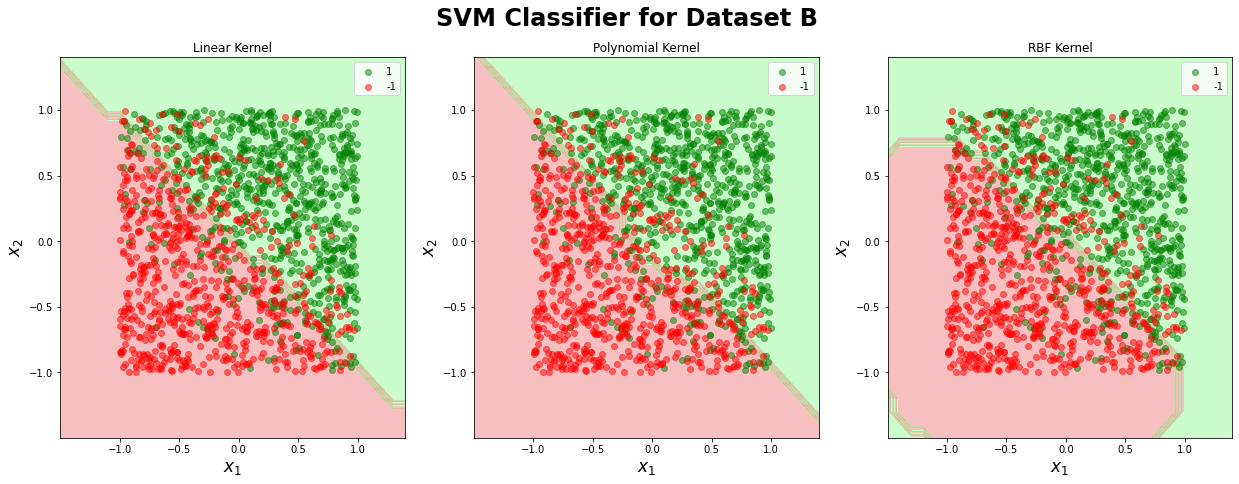

In [5]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

dataset2_A = np.load('Data/dataset_A.npz')
dataset2_B = np.load('Data/dataset_B.npz')

X_train2_A = dataset2_A['arr_0']
Y_train2_A = dataset2_A['arr_1']
X_test2_A = dataset2_A['arr_2']
Y_test2_A = dataset2_A['arr_3']

X_train2_B = dataset2_B['arr_0']
Y_train2_B = dataset2_B['arr_1']
X_test2_B = dataset2_B['arr_2']
Y_test2_B = dataset2_B['arr_3']


X_axis1, Y_axis1 = np.meshgrid(np.arange(start = X_train2_A[:, 0].min() - 0.5, stop = X_train2_A[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train2_A[:, 1].min() - 0.5, stop = X_train2_A[:, 1].max() + 0.5, step = 0.1))
X_test1 = np.array([X_axis1.ravel(), Y_axis1.ravel()]).T


X_axis2, Y_axis2 = np.meshgrid(np.arange(start = X_train2_B[:, 0].min() - 0.5, stop = X_train2_B[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train2_B[:, 1].min() - 0.5, stop = X_train2_B[:, 1].max() + 0.5, step = 0.1))
X_test2 = np.array([X_axis2.ravel(), Y_axis2.ravel()]).T


plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('SVM Classifier for Dataset A', fontweight='bold',fontsize=24)

#Data A

#Linear
Y_pred = train_svm(X_train2_A,Y_train2_A,reg_param=10,kernel='linear',kernel_param=1).predict(X_test1)
Z = Y_pred.reshape(X_axis1.shape)
ax[0].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[0].scatter(X_train2_A[Y_train2_A==1][:,0],X_train2_A[Y_train2_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[0].scatter(X_train2_A[Y_train2_A==-1][:,0],X_train2_A[Y_train2_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[0].set_title('Linear Kernel')
ax[0].legend()
ax[0].set_xlabel('$x_1$',fontsize=17)
ax[0].set_ylabel('$x_2$',fontsize=17)


#Poly
Y_pred = train_svm(X_train2_A,Y_train2_A,reg_param=0.1,kernel='poly',kernel_param=3).predict(X_test1)
Z = Y_pred.reshape(X_axis1.shape)
ax[1].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[1].scatter(X_train2_A[Y_train2_A==1][:,0],X_train2_A[Y_train2_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[1].scatter(X_train2_A[Y_train2_A==-1][:,0],X_train2_A[Y_train2_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[1].set_title('Polynomial Kernel')
ax[1].legend()
ax[1].set_xlabel('$x_1$',fontsize=17)
ax[1].set_ylabel('$x_2$',fontsize=17)

#RBF
Y_pred = train_svm(X_train2_A,Y_train2_A,reg_param=0.1,kernel='rbf',kernel_param=100).predict(X_test1)
Z = Y_pred.reshape(X_axis1.shape)
ax[2].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[2].scatter(X_train2_A[Y_train2_A==1][:,0],X_train2_A[Y_train2_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[2].scatter(X_train2_A[Y_train2_A==-1][:,0],X_train2_A[Y_train2_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[2].set_title('RBF Kernel')
ax[2].legend()
ax[2].set_xlabel('$x_1$',fontsize=17)
ax[2].set_ylabel('$x_2$',fontsize=17)

plt.show()

fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('SVM Classifier for Dataset B', fontweight='bold',fontsize=24)

#Data B

#Linear
Y_pred = train_svm(X_train2_B,Y_train2_B,reg_param=0.1,kernel='linear',kernel_param=1).predict(X_test2)
Z = Y_pred.reshape(X_axis2.shape)
ax[0].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[0].scatter(X_train2_B[Y_train2_B==1][:,0],X_train2_B[Y_train2_B==1][:,1], color = 'green',alpha=0.5,label='1')
ax[0].scatter(X_train2_B[Y_train2_B==-1][:,0],X_train2_B[Y_train2_B==-1][:,1], color = 'red',alpha=0.5,label='-1')
ax[0].set_title('Linear Kernel')
ax[0].legend()
ax[0].set_xlabel('$x_1$',fontsize=17)
ax[0].set_ylabel('$x_2$',fontsize=17)


#Poly
Y_pred = train_svm(X_train2_B,Y_train2_B,reg_param=10,kernel='poly',kernel_param=3).predict(X_test2)
Z = Y_pred.reshape(X_axis2.shape)
ax[1].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[1].scatter(X_train2_B[Y_train2_B==1][:,0],X_train2_B[Y_train2_B==1][:,1], color = 'green',alpha=0.5,label='1')
ax[1].scatter(X_train2_B[Y_train2_B==-1][:,0],X_train2_B[Y_train2_B==-1][:,1], color = 'red',alpha=0.5,label='-1')
ax[1].set_title('Polynomial Kernel')
ax[1].legend()
ax[1].set_xlabel('$x_1$',fontsize=17)
ax[1].set_ylabel('$x_2$',fontsize=17)


#RBF
Y_pred = train_svm(X_train2_B,Y_train2_B,reg_param=0.1,kernel='rbf',kernel_param=10).predict(X_test2)
Z = Y_pred.reshape(X_axis2.shape)
ax[2].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[2].scatter(X_train2_B[Y_train2_B==1][:,0],X_train2_B[Y_train2_B==1][:,1], color = 'green',alpha=0.5,label='1')
ax[2].scatter(X_train2_B[Y_train2_B==-1][:,0],X_train2_B[Y_train2_B==-1][:,1], color = 'red',alpha=0.5,label='-1')
ax[2].set_title('RBF Kernel')
ax[2].legend()
ax[2].set_xlabel('$x_1$',fontsize=17)
ax[2].set_ylabel('$x_2$',fontsize=17)

plt.show()



# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [6]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

def H(p):
    
    if p < 1e-2 or p > 1 - 1e-2:
        return 0
    else:
        return p*np.log2(1/p) + (1-p)*np.log2(1/(1-p))

def split(X, Y, num_nodes_stop, criterion):
    
    n = X.shape[0]
    d = X.shape[1]
    
    if criterion == 'accuracy':
        max_accuracy = 0
        for i in range(d):
            for j in np.linspace(np.min(X[:,i]), np.max(X[:,i]), 10):
                Y_pred = np.ones((n,))
                Y_pred[X[:,i]<=j] = -1
                accuracy = np.sum(Y == Y_pred)/n
                if accuracy < 0.5:
                    accuracy = 1 - accuracy
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    opt_attribute = i
                    opt_threshold = j
    
    elif criterion == 'entropy':
        min_entropy = 100
        for i in range(d):
            for j in np.linspace(np.min(X[:,i]), np.max(X[:,i]), 10):
                p_l = (Y[X[:,i]<=j].shape[0]/n)
                q_l = (np.sum(Y[X[:,i]<=j] == 1)/n)
                p_r = (Y[X[:,i]>j].shape[0]/n)
                q_r = (np.sum(Y[X[:,i]>j] == 1)/n)
                H_l = H(q_l)
                H_r = H(q_r)
                entropy = p_l*H_l + p_r*H_r
                if entropy < min_entropy:
                    min_entropy = entropy
                    opt_attribute = i
                    opt_threshold = j
                
    else:
        print(criterion+' is not a valid criterion')
        return None
    
    X_left = X[X[:,opt_attribute]<=opt_threshold]
    Y_left = Y[X[:,opt_attribute]<=opt_threshold]
    X_right = X[X[:,opt_attribute]>opt_threshold]
    Y_right = Y[X[:,opt_attribute]>opt_threshold]
    
    return X_left, Y_left, X_right, Y_right, opt_attribute, opt_threshold

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy', node_number=0):
    """ Returns a decision tree trained on X and Y and the number of nodes in the tree. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    n = X.shape[0]
    
    tree = []
    
    if n == 0:
        node_number += 1
        node = (node_number, None, None, 1)
        tree.append(node)
        return tree, node_number
    elif np.sum(Y[Y==1]) == n:
        node_number += 1
        node = (node_number, None, None, 1)
        tree.append(node)
        return tree, node_number
    elif np.sum(Y[Y==-1]) == n:
        node_number += 1
        node = (node_number, None, None, -1)
        tree.append(node)
        return tree, node_number
    elif n < num_nodes_stop:
        node_number += 1
        if np.sum(Y[Y==1])/n > 0.5:
            node = (node_number, None, None, 1)
        else:
            node = (node_number, None, None, -1)
        tree.append(node)
        return tree, node_number
    else:
        X_left, Y_left, X_right, Y_right, opt_attribute, opt_threshold = split(X, Y, num_nodes_stop, criterion)
        node_number += 1
        node = (node_number, opt_attribute, opt_threshold, None)
        tree.append(node)
        if X_left.shape[0] != 0 and X_right.shape[0] != 0:
            left_tree, node_number = train_decision_tree(X_left, Y_left, num_nodes_stop, criterion, node_number)
            right_tree, node_number = train_decision_tree(X_right, Y_right, num_nodes_stop, criterion, node_number)
            return tree + left_tree + right_tree, node_number
        else:
            node_number +=1
            if X_left.shape[0] != 0:
                if np.sum(Y_left[Y_left==1])/X_left.shape[0] > 0.5:
                    node1 = (node_number, None, None, 1)
                    node2 = (node_number+1, None, None, -1)
                else:
                    node1 = (node_number, None, None, -1)
                    node2 = (node_number+1, None, None, 1)
            else:
                if np.sum(Y_right[Y_right==1])/X_right.shape[0] > 0.5:
                    node1 = (node_number, None, None, -1)
                    node2 = (node_number+1, None, None, 1)
                else:
                    node1 = (node_number, None, None, 1)
                    node2 = (node_number+1, None, None, -1)
            nodes = [node1, node2]
            return tree + nodes, node_number+1


def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    
    n = test_X.shape[0]
    
    Y_pred = np.ones((n,))
    
    for i in range(n):
        exit = 0
        for node in tree:
            if exit == 0:
                if node[3] == None:
                    if test_X[i, node[1]] <= node[2]:
                        num_split_nodes = 0
                        num_leaf_nodes = 0
                        continue
                    else:
                        exit = 1
                        num_split_nodes = 0
                        num_leaf_nodes = 0
                        continue
                else:
                    Y_pred[i] = node[3]
                    break
            else:
                if node[3] == None:
                    num_split_nodes += 1
                    continue
                else:
                    num_leaf_nodes += 1
                    if num_leaf_nodes > num_split_nodes:
                        exit = 0
                        continue
                    else:
                        continue
            
    return Y_pred

In [ ]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

dataset3_A = np.load('Data/dataset_A.npz')
dataset3_B = np.load('Data/dataset_B.npz')
dataset3_C = np.load('Data/dataset_C.npz')
dataset3_D = np.load('Data/dataset_D.npz')

X_train3_A = dataset3_A['arr_0']
Y_train3_A = dataset3_A['arr_1']
X_test3_A = dataset3_A['arr_2']
Y_test3_A = dataset3_A['arr_3']
indices = np.random.choice(range(X_train3_A.shape[0]),X_train3_A.shape[0]//5)
X_val3_A = X_train3_A[indices,:]
X_train_for_val3_A = np.delete(X_train3_A,indices,axis=0)
Y_val3_A = Y_train3_A[indices]
Y_train_for_val3_A = np.delete(Y_train3_A,indices,axis=0)


X_train3_B = dataset3_B['arr_0']
Y_train3_B = dataset3_B['arr_1']
X_test3_B = dataset3_B['arr_2']
Y_test3_B = dataset3_B['arr_3']
indices = np.random.choice(range(X_train3_B.shape[0]),X_train3_B.shape[0]//5)
X_val3_B = X_train3_B[indices,:]
X_train_for_val3_B = np.delete(X_train3_B,indices,axis=0)
Y_val3_B = Y_train3_B[indices]
Y_train_for_val3_B = np.delete(Y_train3_B,indices,axis=0)

X_train3_C = dataset3_C['arr_0']
Y_train3_C = dataset3_C['arr_1']
X_test3_C = dataset3_C['arr_2']
Y_test3_C = dataset3_C['arr_3']
indices = np.random.choice(range(X_train3_C.shape[0]),X_train3_C.shape[0]//5)
X_val3_C = X_train3_C[indices,:]
X_train_for_val3_C = np.delete(X_train3_C,indices,axis=0)
Y_val3_C = Y_train3_C[indices]
Y_train_for_val3_C = np.delete(Y_train3_C,indices,axis=0)

X_train3_D = dataset3_D['arr_0']
Y_train3_D = dataset3_D['arr_1']
X_test3_D = dataset3_D['arr_2']
Y_test3_D = dataset3_D['arr_3']
indices = np.random.choice(range(X_train3_D.shape[0]),X_train3_D.shape[0]//5)
X_val3_D = X_train3_D[indices,:]
X_train_for_val3_D = np.delete(X_train3_D,indices,axis=0)
Y_val3_D = Y_train3_D[indices]
Y_train_for_val3_D = np.delete(Y_train3_D,indices,axis=0)

# Dataset A
#print('\n\nDataset A')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_nodes_stop in [1, 10, 50, 100, 200]:
        tree, number_of_nodes = train_decision_tree(X_train_for_val3_A, Y_train_for_val3_A, num_nodes_stop, criterion)
        Y_pred_val = eval_decision_tree(tree, X_val3_A)
        val_accuracy = np.sum(Y_pred_val == Y_val3_A)/Y_val3_A.shape[0]
        val_loss = 1 - val_accuracy
        if min_loss >= val_loss:
            min_loss = val_loss
            num_nodes_stop_opt = num_nodes_stop
    #print('\nCriterion: '+str(criterion))
    #print('Best node size: '+str(num_nodes_stop_opt))
    tree, number_of_nodes = train_decision_tree(X_train3_A, Y_train3_A, num_nodes_stop_opt, criterion)
    Y_pred_train = eval_decision_tree(tree, X_train3_A)
    training_accuracy = np.sum(Y_pred_train == Y_train3_A)/Y_train3_A.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_decision_tree(tree, X_test3_A)
    test_accuracy = np.sum(Y_pred_test == Y_test3_A)/Y_test3_A.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))
    
# Dataset B
#print('\n\nDataset B')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_nodes_stop in [1, 10, 50, 100, 200]:
        tree, number_of_nodes = train_decision_tree(X_train_for_val3_B, Y_train_for_val3_B, num_nodes_stop, criterion)
        Y_pred_val = eval_decision_tree(tree, X_val3_B)
        val_accuracy = np.sum(Y_pred_val == Y_val3_B)/Y_val3_B.shape[0]
        val_loss = 1 - val_accuracy
        if min_loss >= val_loss:
            min_loss = val_loss
            num_nodes_stop_opt = num_nodes_stop
    #print('\nCriterion: '+str(criterion))
    #print('Best node size: '+str(num_nodes_stop_opt))
    tree, number_of_nodes = train_decision_tree(X_train3_B, Y_train3_B, num_nodes_stop_opt, criterion)
    Y_pred_train = eval_decision_tree(tree, X_train3_B)
    training_accuracy = np.sum(Y_pred_train == Y_train3_B)/Y_train3_B.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_decision_tree(tree, X_test3_B)
    test_accuracy = np.sum(Y_pred_test == Y_test3_B)/Y_test3_B.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))

# Dataset C
#print('\n\nDataset C')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_nodes_stop in [1, 10, 50, 100, 200]:
        tree, number_of_nodes = train_decision_tree(X_train_for_val3_C, Y_train_for_val3_C, num_nodes_stop, criterion)
        Y_pred_val = eval_decision_tree(tree, X_val3_C)
        val_accuracy = np.sum(Y_pred_val == Y_val3_C)/Y_val3_C.shape[0]
        val_loss = 1 - val_accuracy
        if min_loss >= val_loss:
            min_loss = val_loss
            num_nodes_stop_opt = num_nodes_stop
    #print('\nCriterion: '+str(criterion))
    #print('Best node size: '+str(num_nodes_stop_opt))
    tree, number_of_nodes = train_decision_tree(X_train3_C, Y_train3_C, num_nodes_stop_opt, criterion)
    Y_pred_train = eval_decision_tree(tree, X_train3_C)
    training_accuracy = np.sum(Y_pred_train == Y_train3_C)/Y_train3_C.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_decision_tree(tree, X_test3_C)
    test_accuracy = np.sum(Y_pred_test == Y_test3_C)/Y_test3_C.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))
    
# Dataset D
#print('\n\nDataset D')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_nodes_stop in [1, 10, 50, 100, 200]:
        tree, number_of_nodes = train_decision_tree(X_train_for_val3_D, Y_train_for_val3_D, num_nodes_stop, criterion)
        Y_pred_val = eval_decision_tree(tree, X_val3_D)
        val_accuracy = np.sum(Y_pred_val == Y_val3_D)/Y_val3_D.shape[0]
        val_loss = 1 - val_accuracy
        if min_loss >= val_loss:
            min_loss = val_loss
            num_nodes_stop_opt = num_nodes_stop
    #print('\nCriterion: '+str(criterion))
    #print('Best node size: '+str(num_nodes_stop_opt))
    tree, number_of_nodes = train_decision_tree(X_train3_D, Y_train3_D, num_nodes_stop_opt, criterion)
    Y_pred_train = eval_decision_tree(tree, X_train3_D)
    training_accuracy = np.sum(Y_pred_train == Y_train3_D)/Y_train3_D.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_decision_tree(tree, X_test3_D)
    test_accuracy = np.sum(Y_pred_test == Y_test3_D)/Y_test3_D.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

##Observations
Changing node size results in a change in accuracy because if the node size (min number of samples required to split the node) is 1 we will create the decision boundary based on the position of every single datapoint which will cause the model to overfit. As we increase the node size accuracy keeps increasing upto a certain point after which it decreases again because the model starts becoming more generic

###Dataset A

Criterion : Accuracy
Node Size = 200
Train 0-1 Loss = 0.083
Test 0-1 Loss = 0.102


Criterion : Entropy
Node Size = 200
Train 0-1 Loss = 0.105
Test 0-1 Loss = 0.122

###Dataset B
Criterion : Accuracy
Node Size = 200
Train 0-1 Loss = 0.215
Test 0-1 Loss = 0.226

Criterion : Entropy
Node Size = 100
Train 0-1 Loss = 0.199
Test 0-1 Loss = 0.222

###Dataset C
Criterion : Accuracy
Node Size = 50
Train 0-1 Loss = 0.109
Test 0-1 Loss = 0.138

Criterion : Entropy
Node Size = 50
Train 0-1 Loss = 0.097
Test 0-1 Loss = 0.138

###Dataset D
Criterion : Accuracy
Node Size = 200
Train 0-1 Loss = 0.050
Test 0-1 Loss = 0.130

Criterion : Entropy
Node Size = 200
Train 0-1 Loss = 0.052
Test 0-1 Loss = 0.089



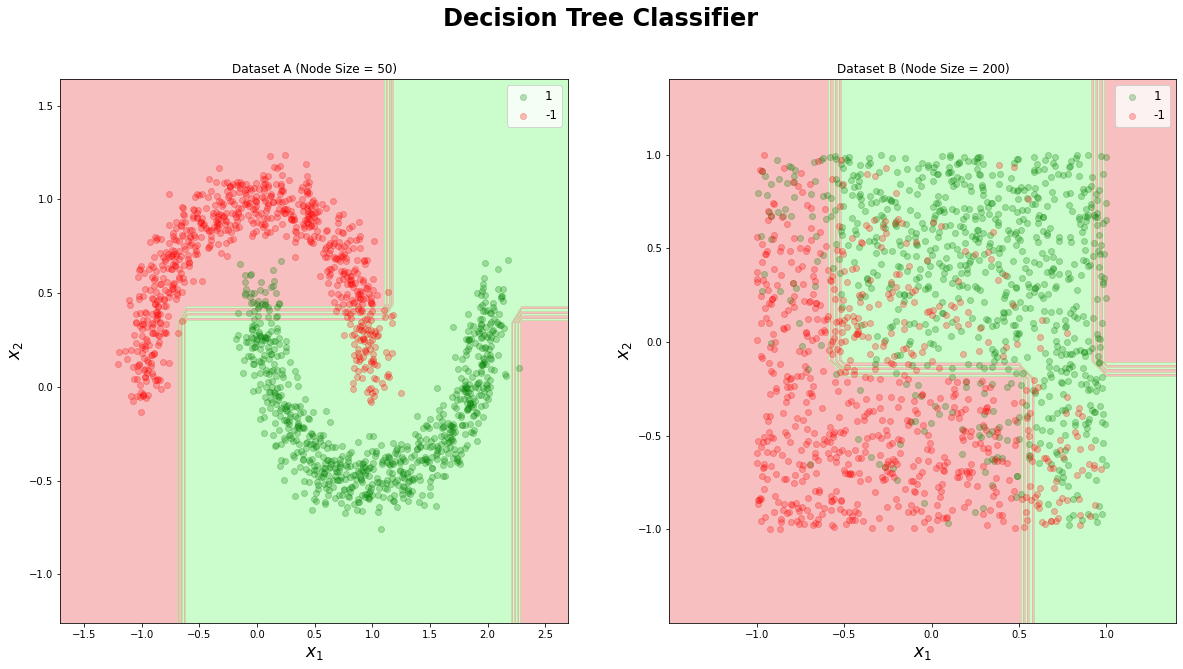

In [7]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

dataset3_A = np.load('Data/dataset_A.npz')
dataset3_B = np.load('Data/dataset_B.npz')

X_train3_A = dataset3_A['arr_0']
Y_train3_A = dataset3_A['arr_1']
X_test3_A = dataset3_A['arr_2']
Y_test3_A = dataset3_A['arr_3']

X_train3_B = dataset3_B['arr_0']
Y_train3_B = dataset3_B['arr_1']
X_test3_B = dataset3_B['arr_2']
Y_test3_B = dataset3_B['arr_3']


X_axis1, Y_axis1 = np.meshgrid(np.arange(start = X_train3_A[:, 0].min() - 0.5, stop = X_train3_A[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train3_A[:, 1].min() - 0.5, stop = X_train3_A[:, 1].max() + 0.5, step = 0.1))
X_test1 = np.array([X_axis1.ravel(), Y_axis1.ravel()]).T


X_axis2, Y_axis2 = np.meshgrid(np.arange(start = X_train3_B[:, 0].min() - 0.5, stop = X_train3_B[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train3_B[:, 1].min() - 0.5, stop = X_train3_B[:, 1].max() + 0.5, step = 0.1))
X_test2 = np.array([X_axis2.ravel(), Y_axis2.ravel()]).T


plt.rcParams['figure.figsize'] = [20,10]
fig,ax = plt.subplots(nrows = 1, ncols = 2)
fig.suptitle('Decision Tree Classifier',fontweight='bold',fontsize=24)

#Data A

tree, number_of_nodes = train_decision_tree(X_train3_A, Y_train3_A, num_nodes_stop=50, criterion='accuracy')
Y_pred = eval_decision_tree(tree, X_test1)
Z = Y_pred.reshape(X_axis1.shape)
ax[0].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[0].scatter(X_train3_A[Y_train3_A==1][:,0],X_train3_A[Y_train3_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[0].scatter(X_train3_A[Y_train3_A==-1][:,0],X_train3_A[Y_train3_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[0].legend(fontsize=12)
ax[0].set_title('Dataset A (Node Size = 50)')
ax[0].set_xlabel('$x_1$',fontsize=17)
ax[0].set_ylabel('$x_2$',fontsize=17)

#Data B

#Linear
tree, number_of_nodes = train_decision_tree(X_train3_B, Y_train3_B, num_nodes_stop=200, criterion='accuracy')
Y_pred = eval_decision_tree(tree, X_test2)
Z = Y_pred.reshape(X_axis2.shape)
ax[1].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[1].scatter(X_train3_B[Y_train3_B==1][:,0],X_train1_B[Y_train3_B==1][:,1], color = 'green',alpha=0.25,label='1')
ax[1].scatter(X_train3_B[Y_train3_B==-1][:,0],X_train3_B[Y_train3_B==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[1].legend(fontsize=12)
ax[1].set_title('Dataset B (Node Size = 200)')
ax[1].set_xlabel('$x_1$',fontsize=17)
ax[1].set_ylabel('$x_2$',fontsize=17)


plt.show()


# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [8]:
# CodeWrite cell
# Write Random Forest classifier. 

def H(p):
    
    if p < 1e-2 or p > 1 - 1e-2:
        return 0
    else:
        return p*np.log2(1/p) + (1-p)*np.log2(1/(1-p))

def split(X, Y, num_nodes_stop, criterion, b):
    
    n = X.shape[0]
    attributes = np.random.choice(range(X.shape[1]), int(b*X.shape[1]))
    
    if criterion == 'accuracy':
        max_accuracy = 0
        for i in attributes:
            for j in np.linspace(np.min(X[:,i]), np.max(X[:,i]), 10):
                Y_pred = np.ones((n,))
                Y_pred[X[:,i]<=j] = -1
                accuracy = np.sum(Y == Y_pred)/n
                if accuracy < 0.5:
                    accuracy = 1 - accuracy
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    opt_attribute = i
                    opt_threshold = j
    
    elif criterion == 'entropy':
        min_entropy = 100
        for i in attributes:
            for j in np.linspace(np.min(X[:,i]), np.max(X[:,i]), 10):
                p_l = (Y[X[:,i]<=j].shape[0]/n)
                q_l = (np.sum(Y[X[:,i]<=j] == 1)/n)
                p_r = (Y[X[:,i]>j].shape[0]/n)
                q_r = (np.sum(Y[X[:,i]>j] == 1)/n)
                H_l = H(q_l)
                H_r = H(q_r)
                entropy = p_l*H_l + p_r*H_r
                if entropy < min_entropy:
                    min_entropy = entropy
                    opt_attribute = i
                    opt_threshold = j
    else:
        print(criterion+' is not a valid criterion')
        return None
    
    X_left = X[X[:,opt_attribute]<=opt_threshold]
    Y_left = Y[X[:,opt_attribute]<=opt_threshold]
    X_right = X[X[:,opt_attribute]>opt_threshold]
    Y_right = Y[X[:,opt_attribute]>opt_threshold]
    
    return X_left, Y_left, X_right, Y_right, opt_attribute, opt_threshold

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy', node_number=0, b=0.5):
    """ Returns a decision tree trained on X and Y and the number of nodes in the tree. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    n = X.shape[0]
    
    tree = []
    
    if n == 0:
        node_number += 1
        node = (node_number, None, None, 1)
        tree.append(node)
        return tree, node_number
    elif np.sum(Y[Y==1]) == n:
        node_number += 1
        node = (node_number, None, None, 1)
        tree.append(node)
        return tree, node_number
    elif np.sum(Y[Y==-1]) == n:
        node_number += 1
        node = (node_number, None, None, -1)
        tree.append(node)
        return tree, node_number
    elif n < num_nodes_stop:
        node_number += 1
        if np.sum(Y[Y==1])/n > 0.5:
            node = (node_number, None, None, 1)
        else:
            node = (node_number, None, None, -1)
        tree.append(node)
        return tree, node_number
    else:
        X_left, Y_left, X_right, Y_right, opt_attribute, opt_threshold = split(X, Y, num_nodes_stop, criterion, b)
        node_number += 1
        node = (node_number, opt_attribute, opt_threshold, None)
        tree.append(node)
        if X_left.shape[0] != 0 and X_right.shape[0] != 0:
            left_tree, node_number = train_decision_tree(X_left, Y_left, num_nodes_stop, criterion, node_number, b)
            right_tree, node_number = train_decision_tree(X_right, Y_right, num_nodes_stop, criterion, node_number, b)
            return tree + left_tree + right_tree, node_number
        else:
            node_number +=1
            if X_left.shape[0] != 0:
                if np.sum(Y_left[Y_left==1])/X_left.shape[0] > 0.5:
                    node1 = (node_number, None, None, 1)
                    node2 = (node_number+1, None, None, -1)
                else:
                    node1 = (node_number, None, None, -1)
                    node2 = (node_number+1, None, None, 1)
            else:
                if np.sum(Y_right[Y_right==1])/X_right.shape[0] > 0.5:
                    node1 = (node_number, None, None, -1)
                    node2 = (node_number+1, None, None, 1)
                else:
                    node1 = (node_number, None, None, 1)
                    node2 = (node_number+1, None, None, -1)
            nodes = [node1, node2]
            return tree + nodes, node_number+1

def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    
    n = test_X.shape[0]
    
    Y_pred = np.ones((n,))
    
    for i in range(n):
        exit = 0
        for node in tree:
            if exit == 0:
                if node[3] == None:
                    if test_X[i, node[1]] <= node[2]:
                        num_split_nodes = 0
                        num_leaf_nodes = 0
                        continue
                    else:
                        exit = 1
                        num_split_nodes = 0
                        num_leaf_nodes = 0
                        continue
                else:
                    Y_pred[i] = node[3]
                    break
            else:
                if node[3] == None:
                    num_split_nodes += 1
                    continue
                else:
                    num_leaf_nodes += 1
                    if num_leaf_nodes > num_split_nodes:
                        exit = 0
                        continue
                    else:
                        continue
                
    return Y_pred


def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, criterion='accuracy', a=0.5, b=0.5):
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    random_forest = []
    
    for i in range(num_trees):
        row_ind = np.random.choice(range(X.shape[0]),int(a*X.shape[0]))
        tree, num_of_nodes = train_decision_tree(X[row_ind,:], Y[row_ind], num_nodes_stop, criterion, b=b)
        random_forest.append(tree)
        
    return random_forest
    

def eval_random_forest(random_forest, test_X):
    """ 
    Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """

    n = test_X.shape[0]
    
    prediction_matrix = np.ones((n,len(random_forest)))
    
    for i in range(len(random_forest)):
        prediction_matrix[:,i] = eval_decision_tree(random_forest[i], test_X)
        
    Y_pred = np.ones((n,))
        
    for i in range(n):
        if np.sum(prediction_matrix[i,:]==1) > len(random_forest)//2:
            Y_pred[i] = 1
        else:
            Y_pred[i] = -1
    
    return Y_pred



In [ ]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

a=0.5
b=0.5
num_nodes_stop=1


dataset4_A = np.load('Data/dataset_A.npz')
dataset4_B = np.load('Data/dataset_B.npz')
dataset4_C = np.load('Data/dataset_C.npz')
dataset4_D = np.load('Data/dataset_D.npz')

X_train4_A = dataset4_A['arr_0']
Y_train4_A = dataset4_A['arr_1']
X_test4_A = dataset4_A['arr_2']
Y_test4_A = dataset4_A['arr_3']
indices = np.random.choice(range(X_train4_A.shape[0]),X_train4_A.shape[0]//5)
X_val4_A = X_train4_A[indices,:]
X_train_for_val4_A = np.delete(X_train4_A,indices,axis=0)
Y_val4_A = Y_train4_A[indices]
Y_train_for_val4_A = np.delete(Y_train4_A,indices,axis=0)


X_train4_B = dataset4_B['arr_0']
Y_train4_B = dataset4_B['arr_1']
X_test4_B = dataset4_B['arr_2']
Y_test4_B = dataset4_B['arr_3']
indices = np.random.choice(range(X_train4_B.shape[0]),X_train4_B.shape[0]//5)
X_val4_B = X_train4_B[indices,:]
X_train_for_val4_B = np.delete(X_train4_B,indices,axis=0)
Y_val4_B = Y_train4_B[indices]
Y_train_for_val4_B = np.delete(Y_train4_B,indices,axis=0)

X_train4_C = dataset4_C['arr_0']
Y_train4_C = dataset4_C['arr_1']
X_test4_C = dataset4_C['arr_2']
Y_test4_C = dataset4_C['arr_3']
indices = np.random.choice(range(X_train4_C.shape[0]),X_train4_C.shape[0]//5)
X_val4_C = X_train4_C[indices,:]
X_train_for_val4_C = np.delete(X_train4_C,indices,axis=0)
Y_val4_C = Y_train4_C[indices]
Y_train_for_val4_C = np.delete(Y_train4_C,indices,axis=0)

X_train4_D = dataset4_D['arr_0']
Y_train4_D = dataset4_D['arr_1']
X_test4_D = dataset4_D['arr_2']
Y_test4_D = dataset4_D['arr_3']
indices = np.random.choice(range(X_train4_D.shape[0]),X_train4_D.shape[0]//5)
X_val4_D = X_train4_D[indices,:]
X_train_for_val4_D = np.delete(X_train4_D,indices,axis=0)
Y_val4_D = Y_train4_D[indices]
Y_train_for_val4_D = np.delete(Y_train4_D,indices,axis=0)

# Dataset A
#print('\n\nDataset A')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_trees in [5,10,50,100]:
        for num_nodes_stop in [1,10,50,100,200]:
            for a in [0.3, 0.5, 0.7, 0.9]:
                for b in [0.5, 1]:
                    rf = train_random_forest(X_train_for_val4_A, Y_train_for_val4_A, num_trees, num_nodes_stop, criterion, a, b)
                    Y_pred_val = eval_random_forest(rf, X_val4_A)
                    val_accuracy = np.sum(Y_pred_val == Y_val4_A)/Y_val4_A.shape[0]
                    val_loss = 1 - val_accuracy
                    if min_loss >= val_loss:
                        min_loss = val_loss
                        num_trees_opt = num_trees
                        num_nodes_stop_opt = num_nodes_stop
                        a_opt = a
                        b_opt = b
    #print('\nCriterion: '+str(criterion))
    #print('Best forest size: '+str(num_trees_opt))
    #print('Best node size: '+str(num_nodes_stop_opt))
    #print('Best a: '+str(a_opt))
    #print('Best b: '+str(b_opt))
    rf = train_random_forest(X_train4_A, Y_train4_A, num_trees_opt, num_nodes_stop, criterion, a, b)
    Y_pred_train = eval_random_forest(rf, X_train4_A)
    training_accuracy = np.sum(Y_pred_train == Y_train4_A)/Y_train4_A.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_random_forest(rf, X_test4_A)
    test_accuracy = np.sum(Y_pred_test == Y_test4_A)/Y_test4_A.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))
    

    
# Dataset B
#print('\n\nDataset B')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_trees in [5,10,50,100]:
        for num_nodes_stop in [1,10,50,100,200]:
            for a in [0.3, 0.5, 0.7, 0.9]:
                for b in [0.5, 1]:
                    rf = train_random_forest(X_train_for_val4_B, Y_train_for_val4_B, num_trees, num_nodes_stop, criterion, a, b)
                    Y_pred_val = eval_random_forest(rf, X_val4_B)
                    val_accuracy = np.sum(Y_pred_val == Y_val4_B)/Y_val4_B.shape[0]
                    val_loss = 1 - val_accuracy
                    if min_loss >= val_loss:
                        min_loss = val_loss
                        num_trees_opt = num_trees
                        num_nodes_stop_opt = num_nodes_stop
                        a_opt = a
                        b_opt = b
    #print('\nCriterion: '+str(criterion))
    #print('Best forest size: '+str(num_trees_opt))
    #print('Best node size: '+str(num_nodes_stop_opt))
    #print('Best a: '+str(a_opt))
    #print('Best b: '+str(b_opt))
    rf = train_random_forest(X_train4_B, Y_train4_B, num_trees_opt, num_nodes_stop, criterion, a, b)
    Y_pred_train = eval_random_forest(rf, X_train4_B)
    training_accuracy = np.sum(Y_pred_train == Y_train4_B)/Y_train4_B.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_random_forest(rf, X_test4_B)
    test_accuracy = np.sum(Y_pred_test == Y_test4_B)/Y_test4_B.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))

# Dataset C
#print('\n\nDataset C')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_trees in [5, 10, 50, 100]:
        for num_nodes_stop in [1,10,50,100,200]:
            for a in [0.3, 0.5, 0.7, 0.9]:
                for b in [0.3, 0.5, 0.7, 0.9]:
                    rf = train_random_forest(X_train_for_val4_C, Y_train_for_val4_C, num_trees, num_nodes_stop, criterion, a, b)
                    Y_pred_val = eval_random_forest(rf, X_val4_C)
                    val_accuracy = np.sum(Y_pred_val == Y_val4_C)/Y_val4_C.shape[0]
                    val_loss = 1 - val_accuracy
                    if min_loss >= val_loss:
                        min_loss = val_loss
                        num_trees_opt = num_trees
                        num_nodes_stop_opt = num_nodes_stop
                        a_opt = a
                        b_opt = b
    #print('\nCriterion: '+str(criterion))
    #print('Best forest size: '+str(num_trees_opt))
    #print('Best node size: '+str(num_nodes_stop_opt))
    #print('Best a: '+str(a_opt))
    #print('Best b: '+str(b_opt))
    rf = train_random_forest(X_train4_C, Y_train4_C, num_trees_opt, num_nodes_stop_opt, criterion, a, b)
    Y_pred_train = eval_random_forest(rf, X_train4_C)
    training_accuracy = np.sum(Y_pred_train == Y_train4_C)/Y_train4_C.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_random_forest(rf, X_test4_C)
    test_accuracy = np.sum(Y_pred_test == Y_test4_C)/Y_test4_C.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))
    
    
    
    
    
# Dataset D
#print('\n\nDataset D')
for criterion in ['accuracy', 'entropy']:
    min_loss = 1
    for num_trees in [5, 10, 50, 100]:
        for num_nodes_stop in [1,10,50,100,200]:
            for a in [0.3, 0.5, 0.7, 0.9]:
                for b in [0.3, 0.5, 0.7, 0.9]:
                    rf = train_random_forest(X_train_for_val4_D, Y_train_for_val4_D, num_trees, num_nodes_stop, criterion, a, b)
                    Y_pred_val = eval_random_forest(rf, X_val4_D)
                    val_accuracy = np.sum(Y_pred_val == Y_val4_D)/Y_val4_D.shape[0]
                    val_loss = 1 - val_accuracy
                    if min_loss >= val_loss:
                        min_loss = val_loss
                        num_trees_opt = num_trees
                        num_nodes_stop_opt = num_nodes_stop
                        a_opt = a
                        b_opt = b
    #print('\nCriterion: '+str(criterion))
    #print('Best forest size: '+str(num_trees_opt))
    #print('Best node size: '+str(num_nodes_stop_opt))
    #print('Best a: '+str(a_opt))
    #print('Best b: '+str(b_opt))
    rf = train_random_forest(X_train4_D, Y_train4_D, num_trees_opt, num_nodes_stop_opt, criterion, a, b)
    Y_pred_train = eval_random_forest(rf, X_train4_D)
    training_accuracy = np.sum(Y_pred_train == Y_train4_D)/Y_train4_D.shape[0]
    training_loss = 1 - training_accuracy
    Y_pred_test = eval_random_forest(rf, X_test4_D)
    test_accuracy = np.sum(Y_pred_test == Y_test4_D)/Y_test4_D.shape[0]
    test_loss = 1 - test_accuracy
    #print('Training Loss: '+str(training_loss))
    #print('Test Loss: '+str(test_loss))



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

##Observations
In this algorithm we create multiple decision trees and decide the outcome by the majority vote. We tune it over fraction of dataset (a), fraction of features (b), node size (min num of samples required for split), and number of trees used. Using more trees make sure that the model is more generalizable which is similar to increasing the node size. The fraction of features and dataset is kept less than 1 at all times so that all trees are not the same. However, for the given dataset we can see that the random forest model performs only slightly better than the decision tree model (for the chosen range of hyperparameters).

###Dataset A
Criterion : Accuracy
Forest Size = 5
Node Size = 1
a = 0.5
b = 0.5
Train 0-1 Loss = 0.083
Test 0-1 Loss = 0.104

Criterion : Entropy
Forest Size = 5
Node Size = 10
a = 0.5
b = 0.5
Train 0-1 Loss = 0.105
Test 0-1 Loss = 0.116

###Dataset B
Criterion : Accuracy
Forest Size = 50
Node Size = 200
a = 0.9
b = 0.5
Train 0-1 Loss = 0.177
Test 0-1 Loss = 0.199

Criterion : Entropy
Forest Size = 10
Node Size = 200
a = 0.7
b = 1
Train 0-1 Loss = 0.202
Test 0-1 Loss = 0.216

###Dataset C
Criterion : Accuracy
Forest Size = 50
Node Size = 10
a = 0.5
b = 0.3
Train 0-1 Loss = 0.073
Test 0-1 Loss = 0.118

Criterion : Entropy
Forest Size = 10
Node Size = 10
a = 0.7
b = 0.3
Train 0-1 Loss = 0.062
Test 0-1 Loss = 0.125

###Dataset D
Criterion : Accuracy
Forest Size = 50
Node Size = 1
a = 0.9
b = 0.3
Train 0-1 Loss = 0.020
Test 0-1 Loss = 0.047

Criterion : Entropy
Forest Size = 50
Node Size = 10
a = 0.3
b = 0.5
Train 0-1 Loss = 0.0375
Test 0-1 Loss = 0.024


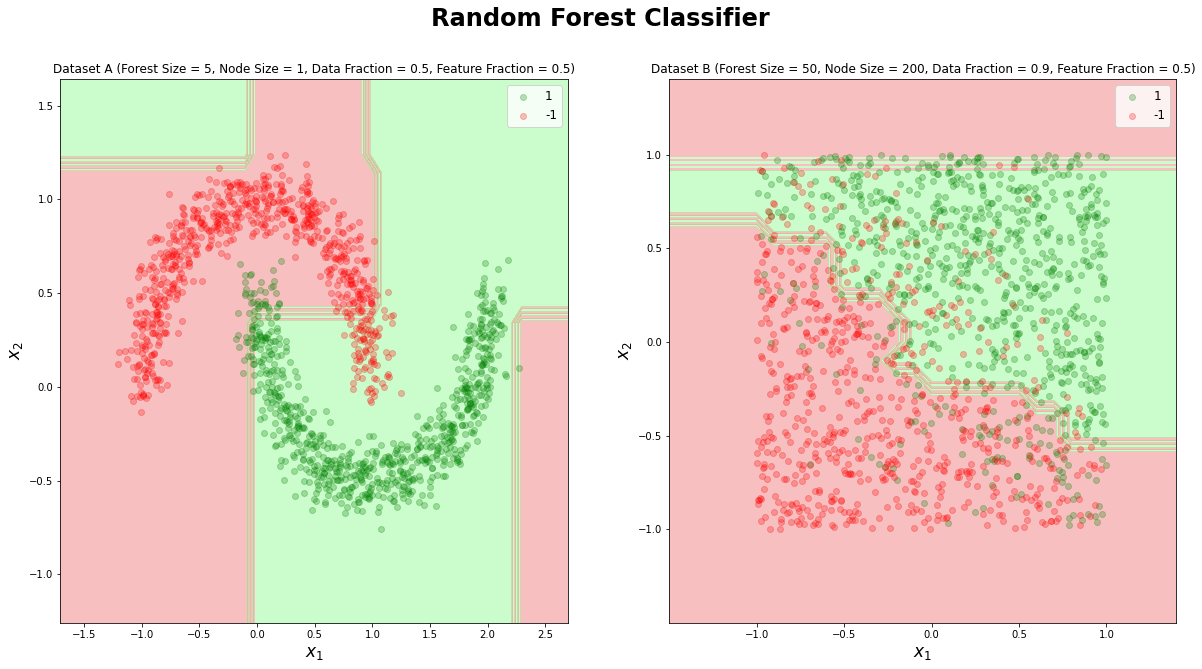

In [9]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

dataset4_A = np.load('Data/dataset_A.npz')
dataset4_B = np.load('Data/dataset_B.npz')

X_train4_A = dataset4_A['arr_0']
Y_train4_A = dataset4_A['arr_1']
X_test4_A = dataset4_A['arr_2']
Y_test4_A = dataset4_A['arr_3']

X_train4_B = dataset4_B['arr_0']
Y_train4_B = dataset4_B['arr_1']
X_test4_B = dataset4_B['arr_2']
Y_test4_B = dataset4_B['arr_3']


X_axis1, Y_axis1 = np.meshgrid(np.arange(start = X_train4_A[:, 0].min() - 0.5, stop = X_train4_A[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train4_A[:, 1].min() - 0.5, stop = X_train4_A[:, 1].max() + 0.5, step = 0.1))
X_test1 = np.array([X_axis1.ravel(), Y_axis1.ravel()]).T


X_axis2, Y_axis2 = np.meshgrid(np.arange(start = X_train4_B[:, 0].min() - 0.5, stop = X_train4_B[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train4_B[:, 1].min() - 0.5, stop = X_train4_B[:, 1].max() + 0.5, step = 0.1))
X_test2 = np.array([X_axis2.ravel(), Y_axis2.ravel()]).T


plt.rcParams['figure.figsize'] = [20,10]
fig,ax = plt.subplots(nrows = 1, ncols = 2)
fig.suptitle('Random Forest Classifier', fontweight='bold',fontsize=24)

#Data A

rf = train_random_forest(X_train4_A, Y_train4_A, num_trees=5, num_nodes_stop=1, criterion='accuracy', a=0.5, b=0.5)
Y_pred = eval_random_forest(rf, X_test1)
Z = Y_pred.reshape(X_axis1.shape)
ax[0].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[0].scatter(X_train4_A[Y_train4_A==1][:,0],X_train4_A[Y_train4_A==1][:,1], color = 'green',alpha=0.25,label='1')
ax[0].scatter(X_train4_A[Y_train4_A==-1][:,0],X_train4_A[Y_train4_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[0].set_title('Dataset A (Forest Size = 5, Node Size = 1, Data Fraction = 0.5, Feature Fraction = 0.5)')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('$x_1$',fontsize=17)
ax[0].set_ylabel('$x_2$',fontsize=17)

#Data B

rf = train_random_forest(X_train4_B, Y_train4_B, num_trees=50, num_nodes_stop=200, criterion='accuracy', a=0.9, b=0.5)
Y_pred = eval_random_forest(rf, X_test2)
Z = Y_pred.reshape(X_axis2.shape)
ax[1].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
ax[1].scatter(X_train3_B[Y_train3_B==1][:,0],X_train1_B[Y_train3_B==1][:,1], color = 'green',alpha=0.25,label='1')
ax[1].scatter(X_train3_B[Y_train3_B==-1][:,0],X_train3_B[Y_train3_B==-1][:,1], color = 'red',alpha=0.25,label='-1')
ax[1].set_title('Dataset B (Forest Size = 50, Node Size = 200, Data Fraction = 0.9, Feature Fraction = 0.5)')
ax[1].legend(fontsize=12)
ax[1].set_xlabel('$x_1$',fontsize=17)
ax[1].set_ylabel('$x_2$',fontsize=17)

plt.show()

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [14]:
# Codewrite cell
# Write code to run here (no plotting)

def split(X, Y, criterion):
    
    n = X.shape[0]
    d = X.shape[1]
    
    if criterion == 'accuracy':
        max_accuracy = 0
        for i in range(d):
            for j in np.linspace(np.min(X[:,i]), np.max(X[:,i]), 10):
                Y_pred = np.ones((n,))
                Y_pred[X[:,i]<=j] = -1
                accuracy = np.sum(Y == Y_pred)/n
                if accuracy < 0.5:
                    accuracy = 1 - accuracy
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    opt_attribute = i
                    opt_threshold = j
                
    else:
        print(criterion+' is not a valid criterion')
        return None
    
    X_left = X[X[:,opt_attribute]<=opt_threshold]
    Y_left = Y[X[:,opt_attribute]<=opt_threshold]
    X_right = X[X[:,opt_attribute]>opt_threshold]
    Y_right = Y[X[:,opt_attribute]>opt_threshold]
    
    return X_left, Y_left, X_right, Y_right, opt_attribute, opt_threshold

def train_decision_tree(X, Y, depth=1, criterion='accuracy', node_number=0, level=0):
    """ Returns a decision tree trained on X and Y and the depth of the tree. 
    Stops splitting nodes when the depth has been reached.
    Split criterion is 'accuracy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    
    n = X.shape[0]
    tree = []
    level += 1
    
    if n == 0:
        node_number += 1
        node = (node_number, None, None, 1)
        tree.append(node)
        return tree, node_number
    elif np.sum(Y[Y==1]) == n:
        node_number += 1
        node = (node_number, None, None, 1)
        tree.append(node)
        return tree, node_number
    elif np.sum(Y[Y==-1]) == n:
        node_number += 1
        node = (node_number, None, None, -1)
        tree.append(node)
        return tree, node_number
    elif level == (depth + 1):
        node_number += 1
        if np.sum(Y[Y==1])/n > 0.5:
            node = (node_number, None, None, 1)
        else:
            node = (node_number, None, None, -1) 
        tree.append(node)
        return tree, node_number
    else:
        X_left, Y_left, X_right, Y_right, opt_attribute, opt_threshold = split(X, Y, criterion)
        node_number += 1
        node = (node_number, opt_attribute, opt_threshold, None)
        tree.append(node)
        if X_left.shape[0] != 0 and X_right.shape[0] != 0:
            left_tree, node_number = train_decision_tree(X_left, Y_left, depth, criterion, node_number, level)
            right_tree, node_number = train_decision_tree(X_right, Y_right, depth, criterion, node_number, level)
            return tree + left_tree + right_tree, node_number
        else:
            node_number +=1
            if X_left.shape[0] != 0:
                if np.sum(Y_left[Y_left==1])/X_left.shape[0] > 0.5:
                    node1 = (node_number, None, None, 1)
                    node2 = (node_number+1, None, None, -1)
                else:
                    node1 = (node_number, None, None, -1)
                    node2 = (node_number+1, None, None, 1)
            else:
                if np.sum(Y_right[Y_right==1])/X_right.shape[0] > 0.5:
                    node1 = (node_number, None, None, -1)
                    node2 = (node_number+1, None, None, 1)
                else:
                    node1 = (node_number, None, None, 1)
                    node2 = (node_number+1, None, None, -1)
            nodes = [node1, node2]
            return tree + nodes, node_number+1

def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""
    
    n = test_X.shape[0]
    
    Y_pred = np.ones((n,))
    
    for i in range(n):
        exit = 0
        for node in tree:
            if exit == 0:
                if node[3] == None:
                    if test_X[i, node[1]] <= node[2]:
                        num_split_nodes = 0
                        num_leaf_nodes = 0
                        continue
                    else:
                        exit = 1
                        num_split_nodes = 0
                        num_leaf_nodes = 0
                        continue
                else:
                    Y_pred[i] = node[3]
                    break
            else:
                if node[3] == None:
                    num_split_nodes += 1
                    continue
                else:
                    num_leaf_nodes += 1
                    if num_leaf_nodes > num_split_nodes:
                        exit = 0
                        continue
                    else:
                        continue
            
    return Y_pred

def gamma_t(w, Y_pred, Y):
    
    gamma = 0.5 - (1/np.sum(w))*(np.matmul(np.transpose(w.reshape((w.shape[0],1))),np.abs((Y_pred-Y).reshape((Y.shape[0],1)))/2))[0,0] 
    
    return gamma
    
def beta_t(gamma):
    
    beta = (0.5+gamma)/(0.5-gamma)
    
    return beta

def augment_data(X, Y, wt):
    
    wt = np.floor(wt/np.min(wt)).astype('int')
    X_augmented = np.ones((np.sum(wt), X.shape[1]))
    Y_augmented = np.ones((np.sum(wt),))
    
    for i in range(X.shape[0]):
        X_augmented[np.sum(wt[:i]):np.sum(wt[:i])+wt[i],:] = X[i,:]
        Y_augmented[np.sum(wt[:i]):np.sum(wt[:i])+wt[i]] = Y[i]
        
    return X_augmented, Y_augmented

def train_adaboost(X, Y, depth=1, criterion='accuracy', iters=50):
    
    m = X.shape[0]
    w = np.ones((m,))
    betas = np.ones((iters,))
    trees = []
    
    for t in range(iters):
        X_aug, Y_aug = augment_data(X, Y, w)
        tree, number_of_nodes = train_decision_tree(X_aug, Y_aug, depth)
        trees.append(tree)
        Y_pred = eval_decision_tree(tree, X)
        gamma = gamma_t(w, Y_pred, Y)
        beta = beta_t(gamma)
        betas[t] = beta
        l_t = np.abs(Y_pred - Y)/2
        for i in range(m):
            w[i] = w[i]*(beta**l_t[i])
    
    return trees, betas

def eval_adaboost(trees, betas, test_X):
    
    n = test_X.shape[0]
    T = len(trees)
    
    h = np.ones((n,T))
    
    for i in range(T):
        h[:,i] = np.log(betas[i])*eval_decision_tree(trees[i], test_X)
        
    Y_pred = np.sign(np.sum(h, axis=1))
    Y_pred = Y_pred.reshape((n,))
    
    return Y_pred

def adaboost_plot(X, Y, X_test, Y_test, depth=1, criterion='accuracy', iters=50):
    
    m = X.shape[0]
    w = np.ones((m,))
    betas = np.ones((iters,))
    trees = []
    test_acc = []
    train_acc = []
    
    for t in range(iters):
        X_aug, Y_aug = augment_data(X, Y, w)
        tree, number_of_nodes = train_decision_tree(X_aug, Y_aug, depth)
        trees.append(tree)
        Y_pred = eval_decision_tree(tree, X)
        gamma = gamma_t(w, Y_pred, Y)
        beta = beta_t(gamma)
        betas[t] = beta
        Y_pred_plot_train = eval_adaboost(trees,betas,X)
        Y_pred_plot_test = eval_adaboost(trees,betas,X_test)
        acc_train = (Y_pred_plot_train == Y).sum()/len(Y)
        acc_test = (Y_pred_plot_test == Y_test).sum()/len(Y_test)
        train_acc.append(acc_train)
        test_acc.append(acc_test)
        l_t = np.abs(Y_pred - Y)/2
        for i in range(m):
            w[i] = w[i]*(beta**l_t[i])
    
    return trees, betas, np.array(train_acc), np.array(test_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


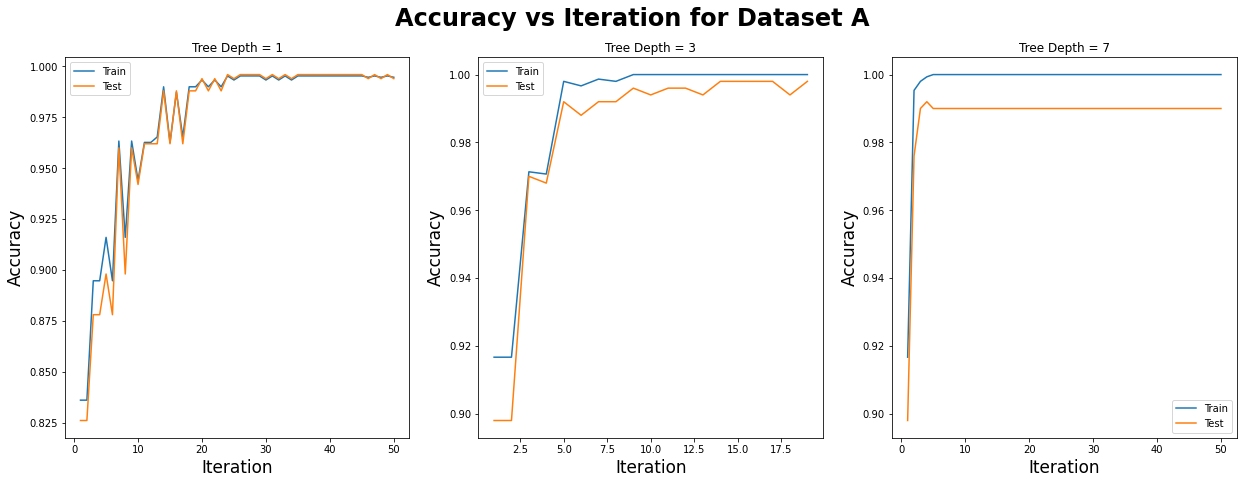

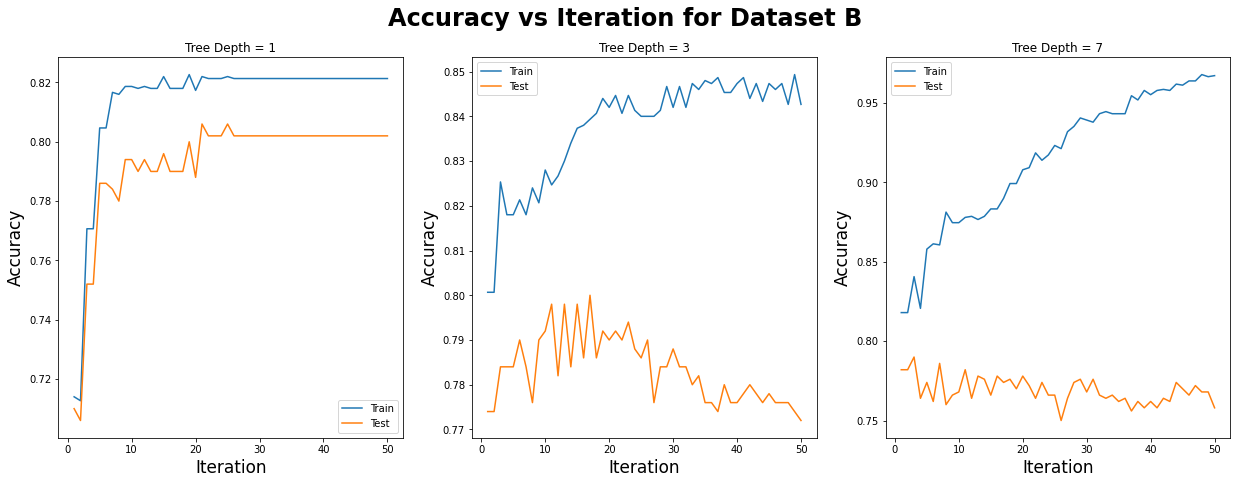

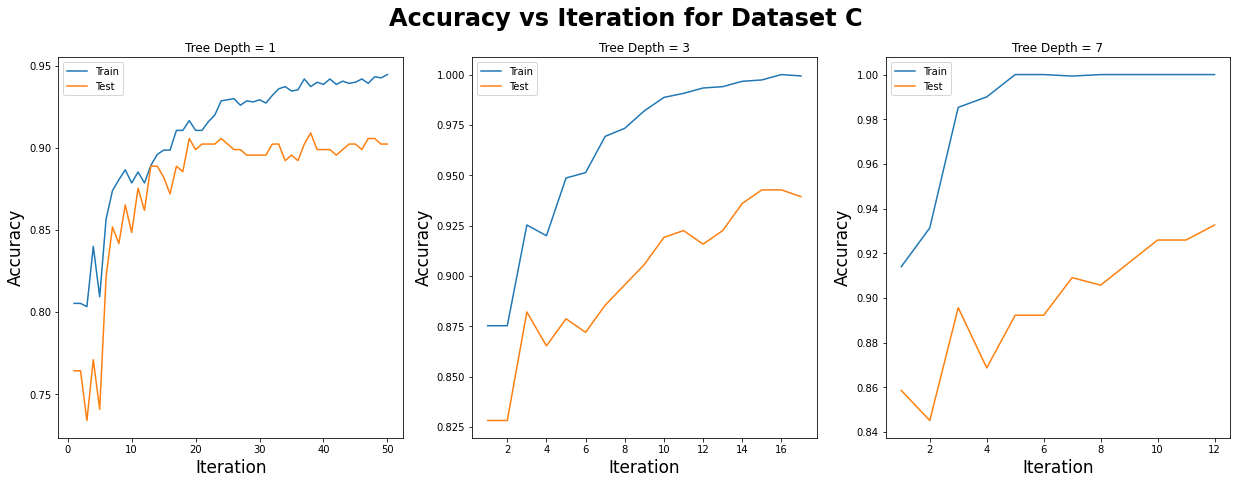

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


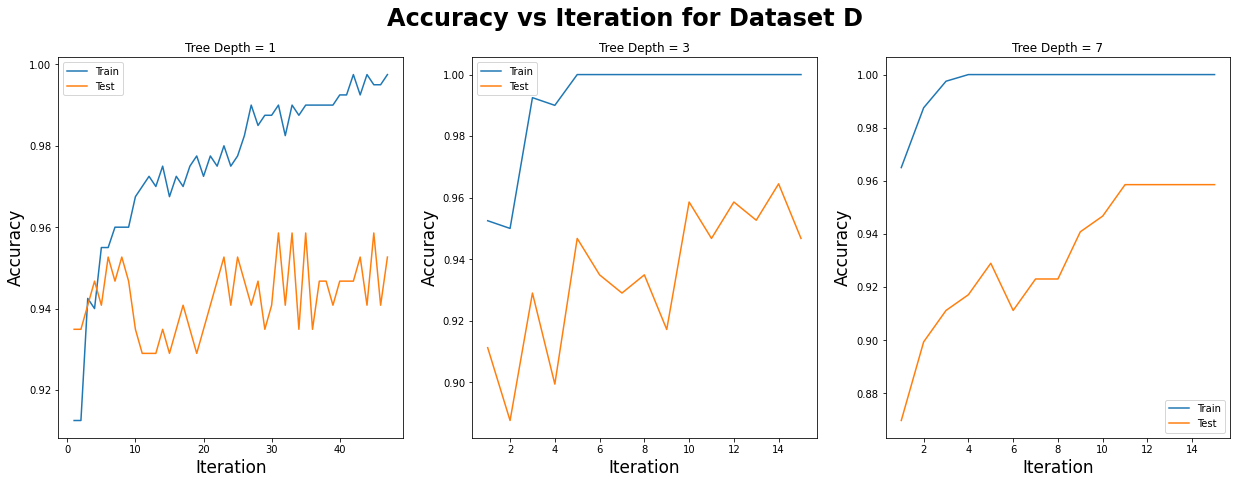

In [15]:
# Codewrite cell 
# Plots for iteration vs error here

dataset5_A = np.load('Data/dataset_A.npz')
dataset5_B = np.load('Data/dataset_B.npz')
dataset5_C = np.load('Data/dataset_C.npz')
dataset5_D = np.load('Data/dataset_D.npz')

X_train5_A = dataset5_A['arr_0']
Y_train5_A = dataset5_A['arr_1']
X_test5_A = dataset5_A['arr_2']
Y_test5_A = dataset5_A['arr_3']

X_train5_B = dataset5_B['arr_0']
Y_train5_B = dataset5_B['arr_1']
X_test5_B = dataset5_B['arr_2']
Y_test5_B = dataset5_B['arr_3']

X_train5_C = dataset5_C['arr_0']
Y_train5_C = dataset5_C['arr_1']
X_test5_C = dataset5_C['arr_2']
Y_test5_C = dataset5_C['arr_3']

X_train5_D = dataset5_D['arr_0']
Y_train5_D = dataset5_D['arr_1']
X_test5_D = dataset5_D['arr_2']
Y_test5_D = dataset5_D['arr_3']

T = 50
depths = [1,3,7]

# Dataset A

plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Accuracy vs Iteration for Dataset A', fontweight='bold',fontsize=24)

for d in range(3):
    if d == 1:
        T = 19
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_A, Y_train5_A, X_test5_A, Y_test5_A, depth=depths[d], iters=T)
    else:
        T = 50
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_A, Y_train5_A, X_test5_A, Y_test5_A, depth=depths[d], iters=T)

    ax[d].plot(list(range(1,T+1)),train_acc,label='Train')
    ax[d].plot(list(range(1,T+1)),test_acc,label='Test')
    ax[d].set_xlabel('Iteration',fontsize=17)
    ax[d].set_ylabel('Accuracy',fontsize=17)
    ax[d].legend()
    ax[d].set_title('Tree Depth = '+str(depths[d]))
    T = 50
    
plt.show()
# Dataset B

plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Accuracy vs Iteration for Dataset B', fontweight='bold',fontsize=24)

for d in range(3):
    T = 50
    trees, betas, train_acc, test_acc = adaboost_plot(X_train5_B, Y_train5_B, X_test5_B, Y_test5_B, depth=depths[d], iters=50)

    ax[d].plot(list(range(1,T+1)),train_acc,label='Train')
    ax[d].plot(list(range(1,T+1)),test_acc,label='Test')
    ax[d].set_xlabel('Iteration',fontsize=17)
    ax[d].set_ylabel('Accuracy',fontsize=17)
    ax[d].legend()
    ax[d].set_title('Tree Depth = '+str(depths[d]))
    
plt.show()

# Dataset C

plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Accuracy vs Iteration for Dataset C', fontweight='bold',fontsize=24)

for d in range(3):
    if d == 1:
        T = 17
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_C, Y_train5_C, X_test5_C, Y_test5_C, depth=depths[d], iters=T)
    if d == 2:
        T = 12
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_C, Y_train5_C, X_test5_C, Y_test5_C, depth=depths[d], iters=T)
    if d == 0:
        T = 50
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_C, Y_train5_C, X_test5_C, Y_test5_C, depth=depths[d], iters=T)

    ax[d].plot(list(range(1,T+1)),train_acc,label='Train')
    ax[d].plot(list(range(1,T+1)),test_acc,label='Test')
    ax[d].set_xlabel('Iteration',fontsize=17)
    ax[d].set_ylabel('Accuracy',fontsize=17)
    ax[d].legend()
    ax[d].set_title('Tree Depth = '+str(depths[d]))
    T = 50
    
plt.show()

# Dataset D
T = 50
plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Accuracy vs Iteration for Dataset D', fontweight='bold',fontsize=24)

for d in range(3):
    if d == 0:
        T = 47
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_D, Y_train5_D, X_test5_D, Y_test5_D, depth=depths[d], iters=T)
    if d == 1:
        T = 15
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_D, Y_train5_D, X_test5_D, Y_test5_D, depth=depths[d], iters=T)
    if d == 2:
        T = 15
        trees, betas, train_acc, test_acc = adaboost_plot(X_train5_D, Y_train5_D, X_test5_D, Y_test5_D, depth=depths[d], iters=T)

    ax[d].plot(list(range(1,T+1)),train_acc,label='Train')
    ax[d].plot(list(range(1,T+1)),test_acc,label='Test')
    ax[d].set_xlabel('Iteration',fontsize=17)
    ax[d].set_ylabel('Accuracy',fontsize=17)
    ax[d].legend()
    ax[d].set_title('Tree Depth = '+str(depths[d]))
    T = 50
    
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


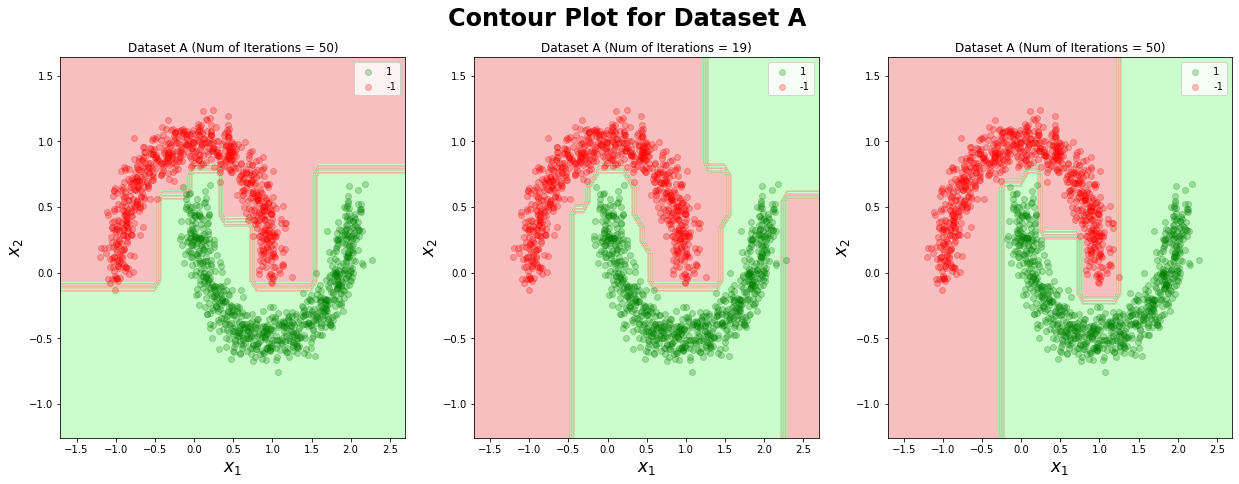

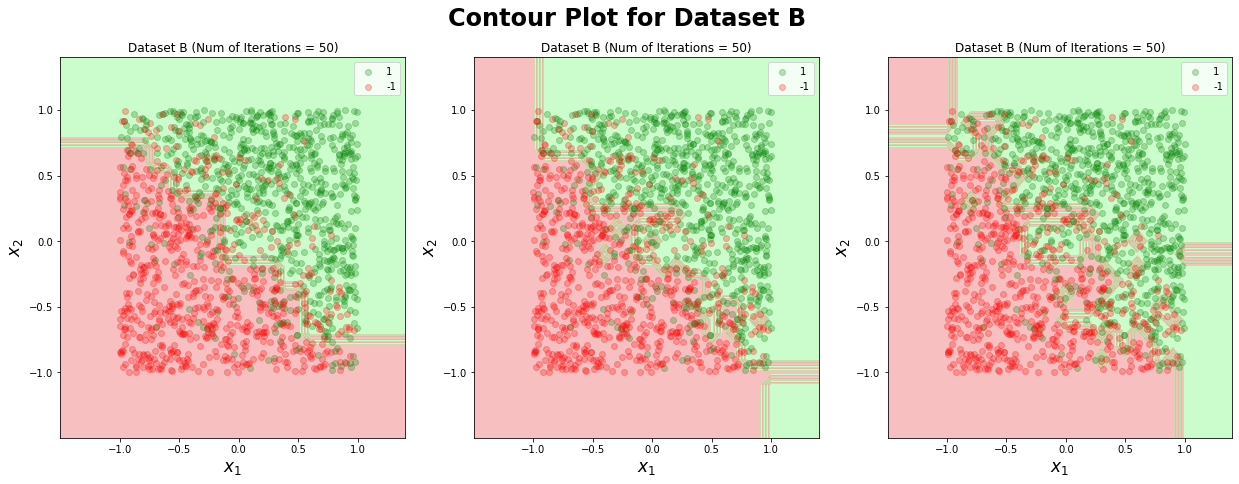

In [16]:
# Codewrite cell 
# Plots for illustrating the classifier here

dataset5_A = np.load('Data/dataset_A.npz')
dataset5_B = np.load('Data/dataset_B.npz')

X_train5_A = dataset5_A['arr_0']
Y_train5_A = dataset5_A['arr_1']
X_test5_A = dataset5_A['arr_2']
Y_test5_A = dataset5_A['arr_3']

X_train5_B = dataset5_B['arr_0']
Y_train5_B = dataset5_B['arr_1']
X_test5_B = dataset5_B['arr_2']
Y_test5_B = dataset5_B['arr_3']


X_axis1, Y_axis1 = np.meshgrid(np.arange(start = X_train5_A[:, 0].min() - 0.5, stop = X_train5_A[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train5_A[:, 1].min() - 0.5, stop = X_train5_A[:, 1].max() + 0.5, step = 0.1))
X_test1 = np.array([X_axis1.ravel(), Y_axis1.ravel()]).T


X_axis2, Y_axis2 = np.meshgrid(np.arange(start = X_train5_B[:, 0].min() - 0.5, stop = X_train5_B[:, 0].max() + 0.5, step = 0.1),
                     np.arange(start = X_train5_B[:, 1].min() - 0.5, stop = X_train5_B[:, 1].max() + 0.5, step = 0.1))
X_test2 = np.array([X_axis2.ravel(), Y_axis2.ravel()]).T


# Dataset A

plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Contour Plot for Dataset A', fontweight='bold',fontsize=24)


for d in range(3):
    if d == 1:
        T = 19
        trees, betas = train_adaboost(X_train5_A, Y_train5_A, depth=depths[d], criterion='accuracy', iters=T)
    else:
        T = 50
        trees, betas = train_adaboost(X_train5_A, Y_train5_A, depth=depths[d], criterion='accuracy', iters=T)
    
    Y_pred = eval_adaboost(trees, betas, X_test1)
    Z = Y_pred.reshape(X_axis1.shape)

    ax[d].contourf(X_axis1, Y_axis1, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
    ax[d].scatter(X_train5_A[Y_train5_A==1][:,0],X_train5_A[Y_train5_A==1][:,1], color = 'green',alpha=0.25,label='1')
    ax[d].scatter(X_train5_A[Y_train5_A==-1][:,0],X_train5_A[Y_train5_A==-1][:,1], color = 'red',alpha=0.25,label='-1')
    ax[d].set_title('Dataset A (Num of Iterations = '+str(T)+')')
    ax[d].set_xlabel('$x_1$',fontsize=17)
    ax[d].set_ylabel('$x_2$',fontsize=17)
    ax[d].legend()
    T = 50
    
plt.show()
# Dataset B

plt.rcParams['figure.figsize'] = [21,7]
fig,ax = plt.subplots(nrows = 1, ncols = 3)
fig.suptitle('Contour Plot for Dataset B', fontweight='bold',fontsize=24)

for d in range(3):
    T = 50
    trees, betas = train_adaboost(X_train5_B, Y_train5_B, depth=depths[d], criterion='accuracy', iters=T)

    Y_pred = eval_adaboost(trees, betas, X_test2)
    Z = Y_pred.reshape(X_axis2.shape)

    ax[d].contourf(X_axis2, Y_axis2, Z, alpha = 0.5, colors = ['lightcoral', 'palegreen'])
    ax[d].scatter(X_train5_B[Y_train5_B==1][:,0],X_train5_B[Y_train5_B==1][:,1], color = 'green',alpha=0.25,label='1')
    ax[d].scatter(X_train5_B[Y_train5_B==-1][:,0],X_train5_B[Y_train5_B==-1][:,1], color = 'red',alpha=0.25,label='-1')
    ax[d].set_title('Dataset B (Num of Iterations = '+str(T)+')')
    ax[d].set_xlabel('$x_1$',fontsize=17)
    ax[d].set_ylabel('$x_2$',fontsize=17)
    ax[d].legend()
    T = 50
    
plt.show()

Textwrite cell:

We can observe that as the number of weak classifiers (observations) increase, our accuracy tends to increase. However, when we have a mixed dataset with large classifiers (large depth of the tree), we observe overfitting. Therefore, increasing the number of weak classifier becomes counterproductive. In the case where we use decision stumps for Dataset B, we can observe that the accuracy increases for a certain number of iterations after which it becomes almost constant (no significant increase in accuracy by adding more classifiers).

As the training accuracy nears 1, the weights increase significantly at each iteration making the dataset extremely large. Therefore, in order to save time the plots for iteration vs accuracy have been stopped prematurely. However, these plots carry the idea of accuracy increasing with the number of iterations.

If we compare the plots that illustrate the classifer, we can notice that the plots for Dataset A tend to outperform any other plot shown before. This shows that boosting does help in increasing the accuracy of the classifier. The classification of Dataset B is not perfect but we consider it to an artifact of the dataset since the data is mixed well and does not show any clear distinction between the positive and negative labels.